In [ ]:
# CELL A — Mount Drive + set paths + ensure folder exists

from google.colab import drive
drive.mount('/content/drive')

import os, glob

# 👉 EDIT this if your folder name/path is different
DRIVE_DIR = "/content/drive/MyDrive/acne clean pigmentation wrinkles"

# Make sure the directory exists (creates it if missing)
os.makedirs(DRIVE_DIR, exist_ok=True)

CSV_IN    = f"{DRIVE_DIR}/labels.csv"           # your original labels file
CSV_OUT   = f"{DRIVE_DIR}/labels_merged.csv"    # we will write this later
MODEL_OUT = f"{DRIVE_DIR}/skin_3label.keras"    # classifier save path
DC_WEIGHTS= f"{DRIVE_DIR}/darkcirclesmodel.pt"       # <-- change if your YOLO file has a different name

print("Drive dir exists? ", os.path.isdir(DRIVE_DIR))
print("labels.csv exists?", os.path.exists(CSV_IN))

# Quick image count in that folder
count_imgs = 0
for ext in ["jpg","jpeg","png","webp","bmp"]:
    count_imgs += len(glob.glob(os.path.join(DRIVE_DIR, f"*.{ext}")))
print("Images found in folder:", count_imgs)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive dir exists?  True
labels.csv exists? True
Images found in folder: 5062


In [ ]:
# CELL B — Merge labels.csv with filename-based inference for any missing files

import os, glob, pandas as pd, re

DRIVE_DIR = "/content/drive/MyDrive/acne clean pigmentation wrinkles"
CSV_IN    = f"{DRIVE_DIR}/labels.csv"
CSV_OUT   = f"{DRIVE_DIR}/labels_merged.csv"

def infer_from_name(name: str):
    n = name.lower()
    acne = int(bool(re.search(r"(?:^|[_-])acne(?:$|[_-])|\bacne\b", n)))
    pig  = int(bool(re.search(r"pigment|melasma|hyperpig", n)))
    wr   = int(bool(re.search(r"wrinkle", n)))
    # if explicitly 'attractive*' → clean
    if n.startswith("attractive"):
        return {"acne":0, "pigmentation":0, "wrinkles":0}
    return {"acne":int(acne>0), "pigmentation":int(pig>0), "wrinkles":int(wr>0)}

# 1) read your labels.csv (source of truth); create skeleton if missing
if os.path.exists(CSV_IN):
    df = pd.read_csv(CSV_IN)
else:
    df = pd.DataFrame(columns=["filepath","acne","pigmentation","wrinkles"])

# normalize columns
df.columns = [c.strip().lower() for c in df.columns]
if "filepath" not in df.columns:
    # try common alternatives
    for alt in ["file","filename","image","img","path","image_path","img_path"]:
        if alt in df.columns:
            df = df.rename(columns={alt:"filepath"})
            break
if "filepath" not in df.columns:
    raise ValueError("labels.csv needs a column for image path or filename (e.g., 'filepath').")

for col in ["acne","pigmentation","wrinkles"]:
    if col not in df.columns: df[col] = 0

# make absolute paths (resolve plain filenames into DRIVE_DIR)
def make_abs(p):
    p = str(p)
    # already absolute and exists → keep
    if os.path.isabs(p) and os.path.exists(p):
        return p
    # otherwise assume file is in DRIVE_DIR
    trial = os.path.join(DRIVE_DIR, os.path.basename(p))
    return trial

df["filepath"] = df["filepath"].apply(make_abs)

# 2) list all images present in the folder
exts = ("*.jpg","*.jpeg","*.png","*.bmp","*.webp")
all_paths = []
for e in exts:
    all_paths += glob.glob(os.path.join(DRIVE_DIR, e))

have = set(os.path.basename(p) for p in df["filepath"])

# 3) add any missing files with labels inferred from filename
new_rows = []
for p in all_paths:
    bn = os.path.basename(p)
    if bn not in have:
        lab = infer_from_name(bn)
        new_rows.append({"filepath": p, **lab})

if new_rows:
    df = pd.concat([df, pd.DataFrame(new_rows)], ignore_index=True)

# 4) drop rows whose files don’t exist; de-duplicate
df = df[df["filepath"].apply(lambda p: os.path.exists(str(p)))].drop_duplicates("filepath").reset_index(drop=True)

# 5) save merged CSV
df.to_csv(CSV_OUT, index=False)
print("✅ Merged CSV saved at:", CSV_OUT)
print("Total images listed:", len(df))
print("Positives:", {c:int(df[c].sum()) for c in ["acne","pigmentation","wrinkles"]})
print(df.head(5))


✅ Merged CSV saved at: /content/drive/MyDrive/acne clean pigmentation wrinkles/labels_merged.csv
Total images listed: 5062
Positives: {'acne': 1406, 'pigmentation': 534, 'wrinkles': 1022}
                                            filepath  acne  wrinkles  \
0  /content/drive/MyDrive/acne clean pigmentation...     1         0   
1  /content/drive/MyDrive/acne clean pigmentation...     1         0   
2  /content/drive/MyDrive/acne clean pigmentation...     1         0   
3  /content/drive/MyDrive/acne clean pigmentation...     1         0   
4  /content/drive/MyDrive/acne clean pigmentation...     1         0   

   pigmentation  clean  
0             0      0  
1             0      0  
2             0      0  
3             0      0  
4             0      0  


In [ ]:
# CELL C — Train/Val split + cap clean-only rows in TRAIN

import pandas as pd
from sklearn.model_selection import train_test_split

DRIVE_DIR = "/content/drive/MyDrive/acne clean pigmentation wrinkles"
CSV_OUT   = f"{DRIVE_DIR}/labels_merged.csv"
CLASSES = ["acne","pigmentation","wrinkles"]

df = pd.read_csv(CSV_OUT).dropna(subset=["filepath"]).reset_index(drop=True)

# 80/20 split
train_df, val_df = train_test_split(df, test_size=0.20, random_state=42, shuffle=True)

# Cap clean-only rows (all zeros across classes) in TRAIN so they don't dominate
MAX_CLEAN_TRAIN = 1200  # tweak if you want more/less clean images used for training
is_clean = (train_df[CLASSES].sum(axis=1) == 0)
if is_clean.sum() > MAX_CLEAN_TRAIN:
    keep_clean = train_df[is_clean].sample(n=MAX_CLEAN_TRAIN, random_state=42)
    train_df = pd.concat([keep_clean, train_df[~is_clean]], ignore_index=True).sample(frac=1, random_state=42)

# Quick stats
def stats(frame, tag):
    total = len(frame)
    pos = {c:int(frame[c].sum()) for c in CLASSES}
    clean = int((frame[CLASSES].sum(axis=1)==0).sum())
    print(f"{tag}: total={total}, clean={clean}, pos={pos}")

stats(train_df, "TRAIN")
stats(val_df, "VAL")

# Save split (handy for debugging/repro)
train_df.to_csv(f"{DRIVE_DIR}/train_split.csv", index=False)
val_df.to_csv(f"{DRIVE_DIR}/val_split.csv", index=False)
print("Saved split CSVs in Drive.")


TRAIN: total=3562, clean=1200, pos={'acne': 1109, 'pigmentation': 425, 'wrinkles': 828}
VAL: total=1013, clean=413, pos={'acne': 297, 'pigmentation': 109, 'wrinkles': 194}
Saved split CSVs in Drive.


In [ ]:
# CELL E (fixed) — pHash dedup with correct API; prevents train↔val leakage

!pip -q install imagededup pillow

import os, pandas as pd
from imagededup.methods import PHash

# === paths (same folder you used) ===
DRIVE_DIR   = "/content/drive/MyDrive/acne clean pigmentation wrinkles"
TRAIN_CSV   = f"{DRIVE_DIR}/train_split.csv"
VAL_CSV     = f"{DRIVE_DIR}/val_split.csv"
TRAIN_OUT   = f"{DRIVE_DIR}/train_split_dedup.csv"
VAL_OUT     = f"{DRIVE_DIR}/val_split_dedup.csv"
DEDUP_REPORT= f"{DRIVE_DIR}/dup_report.csv"

# === load splits and filter to existing files ===
train_df = pd.read_csv(TRAIN_CSV)
val_df   = pd.read_csv(VAL_CSV)
train_df = train_df[train_df["filepath"].apply(lambda p: os.path.exists(str(p)))].reset_index(drop=True)
val_df   = val_df[val_df["filepath"].apply(lambda p: os.path.exists(str(p)))].reset_index(drop=True)
train_df["fname"] = train_df["filepath"].apply(os.path.basename)
val_df["fname"]   = val_df["filepath"].apply(os.path.basename)

# === compute pHash only for files in the splits (avoid scanning CSVs, etc.) ===
ph = PHash()
all_files = pd.concat([train_df["filepath"], val_df["filepath"]], ignore_index=True).unique()
encodings = {}
for p in all_files:
    try:
        encodings[os.path.basename(p)] = ph.encode_image(image_file=p)
    except Exception:
        pass  # skip unreadables

# === find near-duplicates with correct arg ===
# Use a conservative threshold first; 6–8 is common. Start with 6.
dups = ph.find_duplicates(encoding_map=encodings,
                          max_distance_threshold=6,
                          scores=True)

# === collapse symmetric pairs into unique rows ===
rows, seen = [], set()
for a, lst in dups.items():
    for b, dist in lst:
        if a == b:
            continue
        key = tuple(sorted([a, b]))
        if key in seen:
            continue
        seen.add(key)
        rows.append((key[0], key[1], dist))
dup_df = pd.DataFrame(rows, columns=["file_a","file_b","ham_dist"])

# === tag membership and drop cross-split dupes from VAL ===
train_set, val_set = set(train_df["fname"]), set(val_df["fname"])
def where(fn):
    return "train" if fn in train_set else ("val" if fn in val_set else "none")

if not dup_df.empty:
    dup_df["set_a"] = dup_df["file_a"].apply(where)
    dup_df["set_b"] = dup_df["file_b"].apply(where)
    dup_df["cross_split"] = ((dup_df["set_a"]=="train") & (dup_df["set_b"]=="val")) | \
                            ((dup_df["set_a"]=="val") & (dup_df["set_b"]=="train"))
else:
    dup_df = pd.DataFrame(columns=["file_a","file_b","ham_dist","set_a","set_b","cross_split"])

drop_from_val = set()
for _, r in dup_df[dup_df["cross_split"]].iterrows():
    if r["set_a"] == "val": drop_from_val.add(r["file_a"])
    if r["set_b"] == "val": drop_from_val.add(r["file_b"])

before_val = len(val_df)
val_df = val_df[~val_df["fname"].isin(drop_from_val)].reset_index(drop=True)
removed = before_val - len(val_df)

# === save outputs ===
dup_df.to_csv(DEDUP_REPORT, index=False)
train_df.drop(columns=["fname"]).to_csv(TRAIN_OUT, index=False)
val_df.drop(columns=["fname"]).to_csv(VAL_OUT, index=False)

print(f"✅ Dedup complete. Removed {removed} from VAL to prevent leakage.")
print(f"Report: {DEDUP_REPORT}")
print(f"New TRAIN CSV: {TRAIN_OUT} | rows={len(train_df)}")
print(f"New VAL   CSV: {VAL_OUT} | rows={len(val_df)}")


/usr/local/lib/python3.11/dist-packages/imagededup/methods/hashing.py:317: RuntimeWarning: Parameter num_enc_workers has no effect since encodings are already provided
  warnings.warn('Parameter num_enc_workers has no effect since encodings are already provided', RuntimeWarning)
2025-08-10 14:39:57,492: INFO Start: Evaluating hamming distances for getting duplicates
INFO:imagededup.methods.hashing:Start: Evaluating hamming distances for getting duplicates
2025-08-10 14:39:57,496: INFO Start: Retrieving duplicates using Cython Brute force algorithm
INFO:imagededup.handlers.search.retrieval:Start: Retrieving duplicates using Cython Brute force algorithm
100%|██████████| 4575/4575 [00:07<00:00, 589.12it/s] 
2025-08-10 14:40:05,449: INFO End: Retrieving duplicates using Cython Brute force algorithm
INFO:imagededup.handlers.search.retrieval:End: Retrieving duplicates using Cython Brute force algorithm
2025-08-10 14:40:05,451: INFO End: Evaluating hamming distances for getting duplicates
INF

✅ Dedup complete. Removed 58 from VAL to prevent leakage.
Report: /content/drive/MyDrive/acne clean pigmentation wrinkles/dup_report.csv
New TRAIN CSV: /content/drive/MyDrive/acne clean pigmentation wrinkles/train_split_dedup.csv | rows=3562
New VAL   CSV: /content/drive/MyDrive/acne clean pigmentation wrinkles/val_split_dedup.csv | rows=955


In [ ]:
# CELL D (dedup) — Build tf.data pipeline after de-duplication

import os, pandas as pd, tensorflow as tf

DRIVE_DIR = "/content/drive/MyDrive/acne clean pigmentation wrinkles"
TRAIN_CSV = f"{DRIVE_DIR}/train_split_dedup.csv"
VAL_CSV   = f"{DRIVE_DIR}/val_split_dedup.csv"

CLASSES  = ["acne","pigmentation","wrinkles"]
IMG_SIZE = (224, 224)
BATCH    = 32

train_df = pd.read_csv(TRAIN_CSV)
val_df   = pd.read_csv(VAL_CSV)

# Keep only existing files (in case some were moved/deleted)
train_df = train_df[train_df["filepath"].apply(lambda p: tf.io.gfile.exists(str(p)))].reset_index(drop=True)
val_df   = val_df[val_df["filepath"].apply(lambda p: tf.io.gfile.exists(str(p)))].reset_index(drop=True)

def load_row(path, labels):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    return img, tf.cast(labels, tf.float32)

def df_to_ds(frame, shuffle=False):
    paths  = frame["filepath"].astype(str).values
    labels = frame[CLASSES].values.astype("float32")
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(lambda p,l: load_row(p,l), num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle: ds = ds.shuffle(2048, reshuffle_each_iteration=True)
    return ds.batch(BATCH).prefetch(tf.data.AUTOTUNE)

train_ds = df_to_ds(train_df, shuffle=True)
val_ds   = df_to_ds(val_df,   shuffle=False)

# simple sanity prints
print("train batches:", len(list(iter(train_ds))))
print("val batches  :", len(list(iter(val_ds))))
print("train positives:", {c:int(train_df[c].sum()) for c in CLASSES})
print("val positives  :", {c:int(val_df[c].sum()) for c in CLASSES})


train batches: 112
val batches  : 30
train positives: {'acne': 1109, 'pigmentation': 425, 'wrinkles': 828}
val positives  : {'acne': 259, 'pigmentation': 94, 'wrinkles': 191}


In [ ]:
# CELL G — Env check + fix for "No DNN in stream executor"

import os, re, sys
import tensorflow as tf

print("TensorFlow:", tf.__version__)
print("GPUs visible to TF:", tf.config.list_physical_devices('GPU'))

# Show GPU details if available (Colab)
try:
    import subprocess, shlex
    print("\n=== nvidia-smi ===")
    subprocess.run(shlex.split("nvidia-smi"), check=False)
except Exception:
    pass

# If you're on TF >= 2.18, swap to a known-good GPU build (2.17.1) for Colab T4/L4
m = re.match(r"^(\d+)\.(\d+)\.(\d+)", tf.__version__)
ver = tuple(map(int, m.groups())) if m else (0,0,0)

if ver >= (2,18,0):
    print("\nInstalling TensorFlow 2.17.1 GPU wheel for better cuDNN compatibility...")
    # GPU-enabled pip wheel
    !pip -q install "tensorflow[and-cuda]==2.17.1"
    print("✅ Installed TF 2.17.1. Now do: Runtime → Restart runtime, then rerun cells A→B→C→E→D→F.")

# If no GPU is visible, you’re on CPU runtime. Switch to GPU:
if not tf.config.list_physical_devices('GPU'):
    print("\n⚠️ No GPU detected. In Colab: Runtime → Change runtime type → Hardware accelerator: GPU, then rerun A→B→C→E→D→F.")

# (Optional) If you must continue *right now* on CPU to bypass cuDNN, do this at the very top of your notebook:
print("\nTo force CPU (slower but avoids cuDNN):")
print('  Add at the *top* of the notebook, before importing TF:')
print('    import os; os.environ["CUDA_VISIBLE_DEVICES"] = "-1"')


TensorFlow: 2.19.0
GPUs visible to TF: []

=== nvidia-smi ===

Installing TensorFlow 2.17.1 GPU wheel for better cuDNN compatibility...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.4/601.4 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.6/412.6 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 50.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.0/22.0 MB 38.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.9/24.9 MB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 867.7/867.7 kB 37.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 704.7/704.7 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.8/98.8 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.2/125.2 MB 8.1 MB/s e

In [ ]:
# CELL F — Training with AdamW + label smoothing + EarlyStopping + LR plateau + spike detector

import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LambdaCallback
import numpy as np, os

# Reuse from previous cells:
# - train_ds, val_ds (from Cell D dedup)
# - train_df, val_df, CLASSES
IMG_SIZE = (224,224)

# ----- class-weighted BCE with label smoothing -----
pos = train_df[CLASSES].sum(axis=0).values.astype("float32")
neg = float(len(train_df)) - pos
w_pos = tf.constant(neg / tf.maximum(pos, 1.0), dtype=tf.float32)   # rarer class => bigger weight
w_neg = tf.constant(np.ones_like(pos), dtype=tf.float32)

def weighted_bce(y_true, y_pred, smooth=0.05):
    # label smoothing toward 0.5 to reduce overconfidence
    y_true = y_true * (1.0 - smooth) + 0.5 * smooth
    bce = tf.keras.backend.binary_crossentropy(y_true, y_pred)      # shape (batch, n_classes)
    weights = y_true * w_pos + (1.0 - y_true) * w_neg              # per-class weights
    return tf.reduce_mean(bce * weights)

# ----- model -----
base = tf.keras.applications.EfficientNetB0(
    include_top=False, weights="imagenet", input_shape=IMG_SIZE+(3,)
)
base.trainable = False

inp = layers.Input(shape=IMG_SIZE+(3,))
x = layers.RandomFlip("horizontal")(inp)
x = layers.RandomRotation(0.05)(x)
x = layers.RandomZoom(0.1)(x)
x = layers.RandomContrast(0.1)(x)
x = tf.keras.applications.efficientnet.preprocess_input(x*255.0)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.35)(x)
out = layers.Dense(len(CLASSES), activation="sigmoid")(x)
model = Model(inp, out)

model.compile(
    optimizer=tf.keras.optimizers.AdamW(1e-3, weight_decay=1e-4),
    loss=weighted_bce,
    metrics=[tf.keras.metrics.BinaryAccuracy(name="acc", threshold=0.5),
             tf.keras.metrics.AUC(name="auc", multi_label=True),
             tf.keras.metrics.Precision(name="precision"),
             tf.keras.metrics.Recall(name="recall")]
)

# ----- callbacks -----
EPOCHS_MAX = 20
ckpt_path = os.path.join("/content", "skin_3label_best.keras")  # temp; we’ll also save to Drive after FT

early = EarlyStopping(monitor="val_auc", mode="max", patience=5, restore_best_weights=True)
plateau = ReduceLROnPlateau(monitor="val_auc", mode="max", factor=0.5, patience=2, min_lr=1e-6, verbose=1)
ckpt = ModelCheckpoint(ckpt_path, monitor="val_auc", mode="max", save_best_only=True, verbose=1)

# Spike detector: warn if val_acc jumps > 0.20 in one epoch (possible leakage/overfit)
last = {"val_acc": None}
def on_epoch_end(epoch, logs):
    va = logs.get("val_acc")
    if last["val_acc"] is not None and va is not None and (va - last["val_acc"]) > 0.20:
        print(f"⚠️  Suspicious jump in val_acc from {last['val_acc']:.3f} to {va:.3f} at epoch {epoch}")
    last["val_acc"] = va
spike = LambdaCallback(on_epoch_end=on_epoch_end)

# ----- phase 1: train head -----
hist1 = model.fit(
    train_ds, validation_data=val_ds, epochs=EPOCHS_MAX,
    callbacks=[early, plateau, ckpt, spike], verbose=1
)

# ----- light fine-tune: unfreeze last ~30 layers -----
base.trainable = True
for L in base.layers[:-30]:
    L.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.AdamW(1e-5, weight_decay=1e-5),
    loss=weighted_bce,
    metrics=[tf.keras.metrics.BinaryAccuracy(name="acc", threshold=0.5),
             tf.keras.metrics.AUC(name="auc", multi_label=True),
             tf.keras.metrics.Precision(name="precision"),
             tf.keras.metrics.Recall(name="recall")]
)
hist2 = model.fit(
    train_ds, validation_data=val_ds, epochs=8,  # short FT window
    callbacks=[early, plateau, ckpt, spike], verbose=1
)

# Load best weights (highest val_auc) and evaluate once
best = tf.keras.models.load_model(ckpt_path, custom_objects={"weighted_bce": weighted_bce})
print("— Final val metrics —")
best.evaluate(val_ds, verbose=1)

# Save to Drive
DRIVE_DIR = "/content/drive/MyDrive/acne clean pigmentation wrinkles"
best.save(os.path.join(DRIVE_DIR, "skin_3label.keras"))
print("✅ Saved:", os.path.join(DRIVE_DIR, "skin_3label.keras"))


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - acc: 0.7676 - auc: 0.8400 - loss: 0.8121 - precision: 0.5065 - recall: 0.7933
Epoch 1: val_auc improved from -inf to 0.97817, saving model to /content/skin_3label_best.keras
112/112 ━━━━━━━━━━━━━━━━━━━━ 314s 3s/step - acc: 0.7685 - auc: 0.8408 - loss: 0.8105 - precision: 0.5076 - recall: 0.7941 - val_acc: 0.9002 - val_auc: 0.9782 - val_loss: 0.4384 - val_precision: 0.6633 - val_recall: 0.9632 - learning_rate: 0.0010
Epoch 2/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - acc: 0.9360 - auc: 0.9814 - loss: 0.4245 - precision: 0.7965 - recall: 0.9518
Epoch 2: val_auc improved from 0.97817 to 0.98806, saving model to /content/skin_3label_best.keras
112/112 ━━━━━━━━━━━━━━━━━━━━ 242s 2s/step - acc: 0.9360 - auc: 0.9815 - loss: 0.4244 - precision: 0.7967 - recall: 0.9519 - val_acc: 0.9333 - val_auc: 0.9881 - val_loss: 0.3717 - val_precision: 0.7511 - val_recall: 0.9706 - learning_rate: 0.0010


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
ERROR:tornado.application:Exception in callback fu

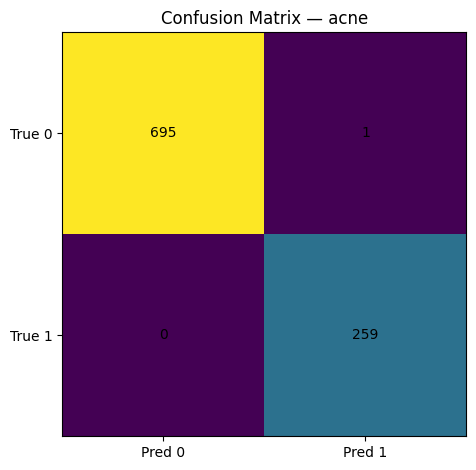

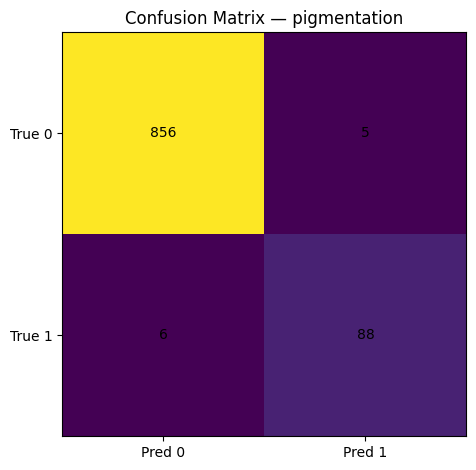

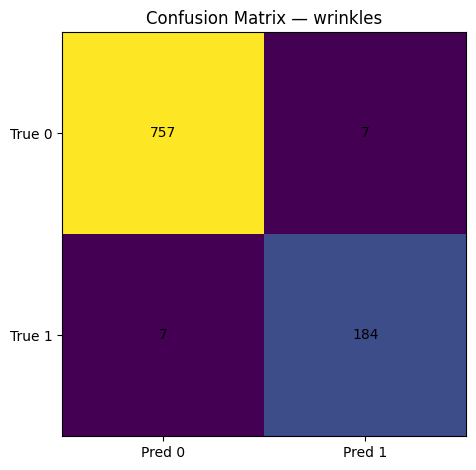

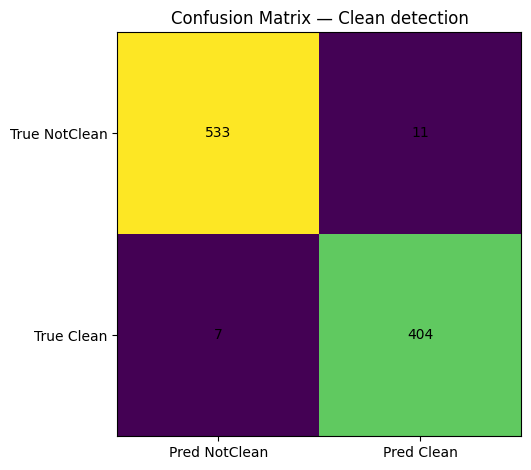

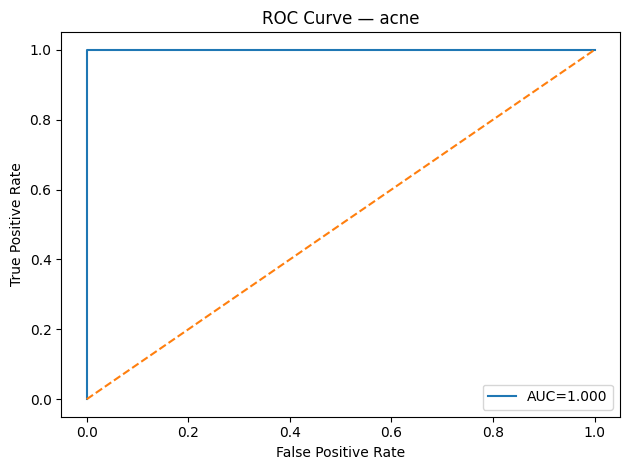

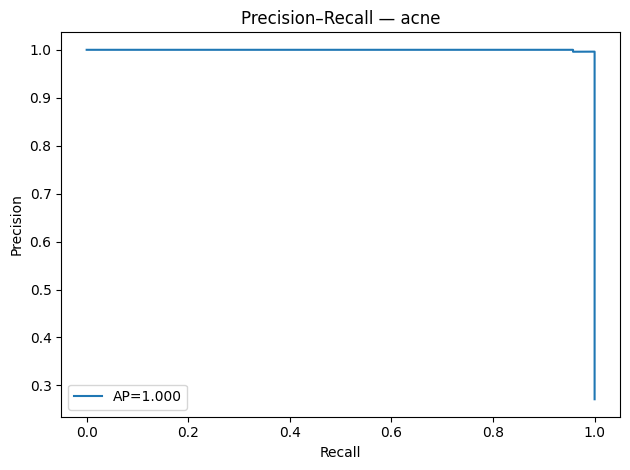

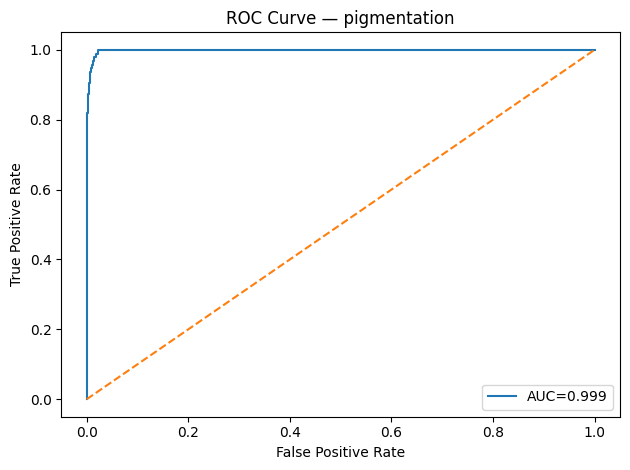

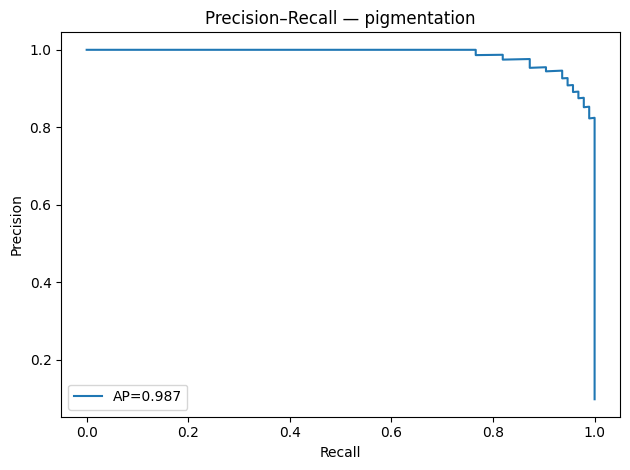

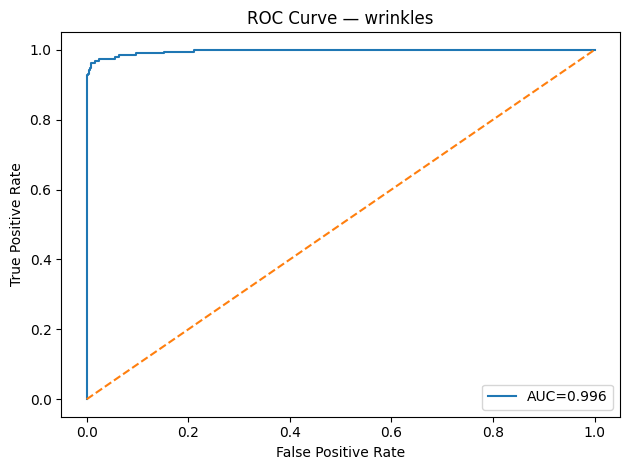

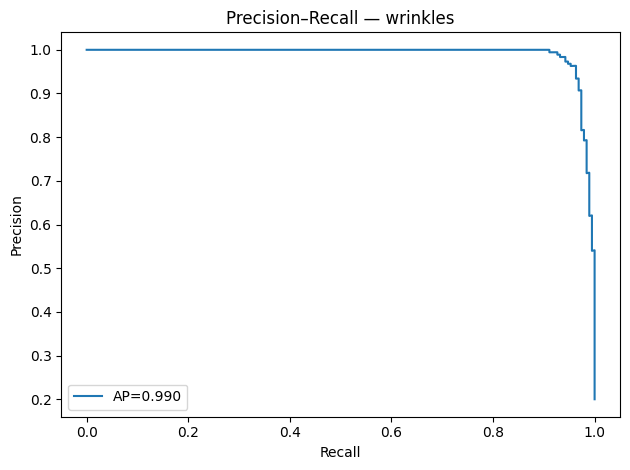

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


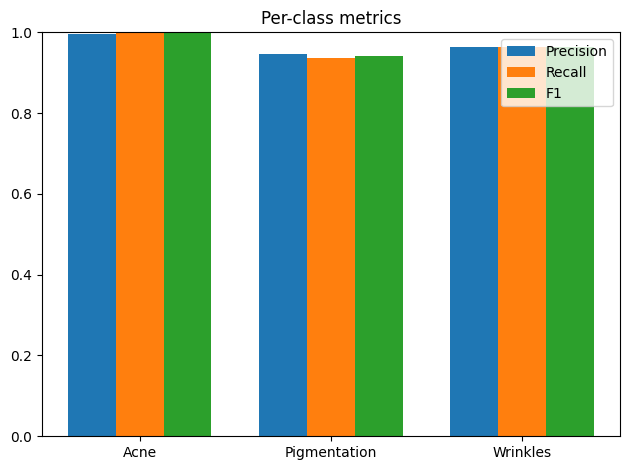

✅ Saved all figures to: /content/drive/MyDrive/acne clean pigmentation wrinkles/models/reports


In [ ]:
# CELL RPT — Full evaluation + graphs + confusion matrices (saves to Drive)

import os, json, numpy as np, pandas as pd, matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import (
    classification_report, multilabel_confusion_matrix, confusion_matrix,
    accuracy_score, roc_curve, auc, precision_recall_curve, average_precision_score, f1_score
)

# === Paths (edit DRIVE_DIR only if your folder name differs) ===
DRIVE_DIR   = "/content/drive/MyDrive/acne clean pigmentation wrinkles"
MODEL_PATH  = os.path.join(DRIVE_DIR, "skin_3label.keras")
VAL_CSV     = os.path.join(DRIVE_DIR, "val_split_dedup.csv")
OUT_DIR     = os.path.join(DRIVE_DIR, "models", "reports")
THR_JSON    = os.path.join(DRIVE_DIR, "models", "thresholds.json")  # optional from Cell T
os.makedirs(OUT_DIR, exist_ok=True)

CLASSES  = ["acne","pigmentation","wrinkles"]
IMG_SIZE = (224,224)
BATCH    = 32

# === Load model (works even if trained with custom loss) ===
def _dummy_loss(y_true, y_pred):
    return tf.keras.backend.binary_crossentropy(y_true, y_pred)
try:
    model = tf.keras.models.load_model(MODEL_PATH, custom_objects={"weighted_bce": _dummy_loss})
except Exception:
    model = tf.keras.models.load_model(MODEL_PATH)

# === Build val dataset ===
val_df = pd.read_csv(VAL_CSV)
val_df = val_df[val_df["filepath"].apply(lambda p: tf.io.gfile.exists(str(p)))].reset_index(drop=True)

def _load_row(path, labels):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    return img, tf.cast(labels, tf.float32)

def _df_to_ds(frame):
    paths  = frame["filepath"].astype(str).values
    labels = frame[CLASSES].values.astype("float32")
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(lambda p,l: _load_row(p,l), num_parallel_calls=tf.data.AUTOTUNE)
    return ds.batch(BATCH).prefetch(tf.data.AUTOTUNE)

val_ds = _df_to_ds(val_df)

# === Collect probabilities on VAL ===
y_true, y_prob, filepaths = [], [], []
for (x, y), fp in zip(val_ds, np.array_split(val_df["filepath"].values, len(val_ds))):
    y_true.append(y.numpy())
    y_prob.append(model.predict(x, verbose=0))
    filepaths.extend(fp.tolist())
y_true = np.vstack(y_true)
y_prob = np.vstack(y_prob)
filepaths = np.array(filepaths)

# === Thresholds: load if present, else auto-tune (max F1 on val) ===
if os.path.exists(THR_JSON):
    with open(THR_JSON) as f:
        best_thr = json.load(f)
    thr = np.array([best_thr.get(c, 0.5) for c in CLASSES], dtype="float32")
else:
    thr = np.zeros(len(CLASSES), dtype="float32")
    for i, c in enumerate(CLASSES):
        ts = np.linspace(0.2, 0.8, 241)
        f1s = [f1_score(y_true[:,i], (y_prob[:,i] >= t).astype(int)) for t in ts]
        thr[i] = float(ts[int(np.argmax(f1s))])
    best_thr = {c: float(thr[i]) for i,c in enumerate(CLASSES)}

y_pred = (y_prob >= thr).astype(int)

# === “Clean” label (derived) & exact-match ===
y_true_clean = (y_true.sum(axis=1) == 0).astype(int)
y_pred_clean = (y_pred.sum(axis=1) == 0).astype(int)

exact_match_acc = accuracy_score(
    np.hstack([y_true, y_true_clean.reshape(-1,1)]),
    np.hstack([y_pred, y_pred_clean.reshape(-1,1)])
)

# === Text reports (printed) ===
print("=== Per-Label Classification Report ===")
print(pd.DataFrame(classification_report(y_true, y_pred, target_names=CLASSES, output_dict=True)).T.round(3))

print("\n=== Clean-Face Detection Report ===")
clean_report = classification_report(
    y_true_clean, y_pred_clean, target_names=["Not Clean","Clean"], output_dict=True
)
print(pd.DataFrame(clean_report).T.round(3))

print(f"\n\uD83D\uDD34 Exact Match Accuracy (all 4 labels): {exact_match_acc*100:.2f}%")
print("Thresholds used:", {c: round(best_thr[c],3) for c in best_thr})

# === Save a CSV with per-sample predictions (handy for QA) ===
pred_csv = os.path.join(OUT_DIR, "val_predictions.csv")
pd.DataFrame({
    "filepath": filepaths,
    **{f"y_true_{c}": y_true[:,i].astype(int) for i,c in enumerate(CLASSES)},
    **{f"y_prob_{c}": y_prob[:,i] for i,c in enumerate(CLASSES)},
    **{f"y_pred_{c}": y_pred[:,i].astype(int) for i,c in enumerate(CLASSES)},
    "y_true_clean": y_true_clean,
    "y_pred_clean": y_pred_clean
}).to_csv(pred_csv, index=False)
print("Saved per-sample predictions:", pred_csv)

# === Confusion matrices per class ===
for i, c in enumerate(CLASSES):
    cm = confusion_matrix(y_true[:,i], y_pred[:,i], labels=[0,1])
    fig = plt.figure()
    plt.imshow(cm, interpolation='nearest')
    plt.title(f"Confusion Matrix — {c}")
    plt.xticks([0,1], ['Pred 0','Pred 1'])
    plt.yticks([0,1], ['True 0','True 1'])
    for (r, col), val in np.ndenumerate(cm):
        plt.text(col, r, int(val), ha='center', va='center')
    plt.tight_layout()
    fig.savefig(os.path.join(OUT_DIR, f"cm_{c}.png"), dpi=160)
    plt.show()

# Clean-vs-NotClean confusion matrix
cm_clean = confusion_matrix(y_true_clean, y_pred_clean, labels=[0,1])
fig = plt.figure()
plt.imshow(cm_clean, interpolation='nearest')
plt.title("Confusion Matrix — Clean detection")
plt.xticks([0,1], ['Pred NotClean','Pred Clean'])
plt.yticks([0,1], ['True NotClean','True Clean'])
for (r, col), val in np.ndenumerate(cm_clean):
    plt.text(col, r, int(val), ha='center', va='center')
plt.tight_layout()
fig.savefig(os.path.join(OUT_DIR, "cm_clean.png"), dpi=160)
plt.show()

# === ROC & PR curves per class ===
for i, c in enumerate(CLASSES):
    # ROC
    fpr, tpr, _ = roc_curve(y_true[:,i], y_prob[:,i])
    roc_auc = auc(fpr, tpr)
    fig = plt.figure()
    plt.plot(fpr, tpr, label=f"AUC={roc_auc:.3f}")
    plt.plot([0,1], [0,1], linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve — {c}")
    plt.legend()
    plt.tight_layout()
    fig.savefig(os.path.join(OUT_DIR, f"roc_{c}.png"), dpi=160)
    plt.show()

    # PR
    P, R, _ = precision_recall_curve(y_true[:,i], y_prob[:,i])
    ap = average_precision_score(y_true[:,i], y_prob[:,i])
    fig = plt.figure()
    plt.plot(R, P, label=f"AP={ap:.3f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision–Recall — {c}")
    plt.legend()
    plt.tight_layout()
    fig.savefig(os.path.join(OUT_DIR, f"pr_{c}.png"), dpi=160)
    plt.show()

# === Bar chart of per-class metrics (P/R/F1) ===
rep = classification_report(y_true, y_pred, target_names=CLASSES, output_dict=True)
prec = [rep[c]["precision"] for c in CLASSES]
rec  = [rep[c]["recall"] for c in CLASSES]
f1   = [rep[c]["f1-score"] for c in CLASSES]

fig = plt.figure()
x = np.arange(len(CLASSES))
w = 0.25
plt.bar(x - w, prec, width=w, label="Precision")
plt.bar(x,     rec,  width=w, label="Recall")
plt.bar(x + w, f1,   width=w, label="F1")
plt.xticks(x, [c.title() for c in CLASSES])
plt.ylim(0, 1.0)
plt.title("Per-class metrics")
plt.legend()
plt.tight_layout()
fig.savefig(os.path.join(OUT_DIR, "bar_metrics.png"), dpi=160)
plt.show()

print("✅ Saved all figures to:", OUT_DIR)


=== Per-Label Classification Report ===
              precision  recall  f1-score  support
acne              0.996   1.000     0.998    259.0
pigmentation      0.946   0.936     0.941     94.0
wrinkles          0.963   0.963     0.963    191.0
micro avg         0.976   0.976     0.976    544.0
macro avg         0.969   0.967     0.968    544.0
weighted avg      0.976   0.976     0.976    544.0
samples avg       0.554   0.556     0.555    544.0

=== Clean-Face Detection Report ===
              precision  recall  f1-score  support
Not Clean         0.987   0.980     0.983  544.000
Clean             0.973   0.983     0.978  411.000
accuracy          0.981   0.981     0.981    0.981
macro avg         0.980   0.981     0.981  955.000
weighted avg      0.981   0.981     0.981  955.000

🔴 Exact Match Accuracy (all 4 labels): 97.49%
Thresholds used: {'acne': 0.565, 'pigmentation': 0.8, 'wrinkles': 0.68}


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


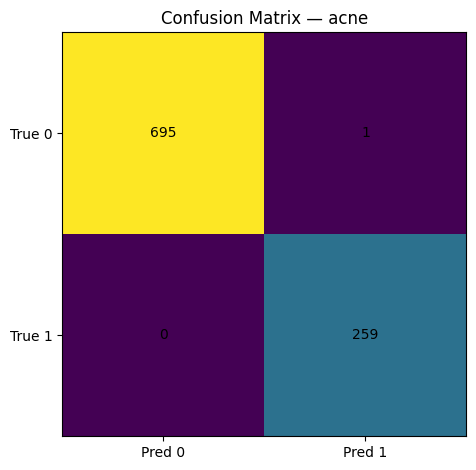

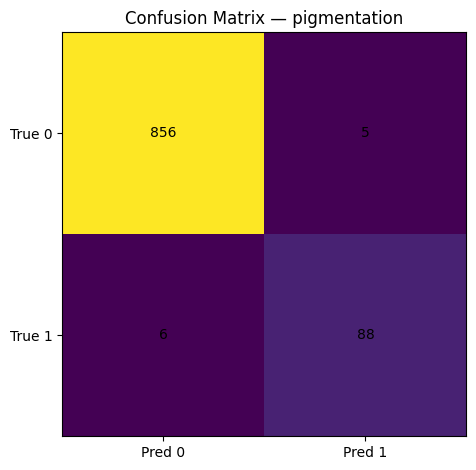

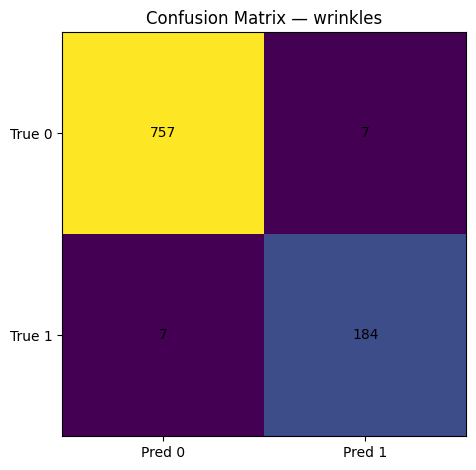

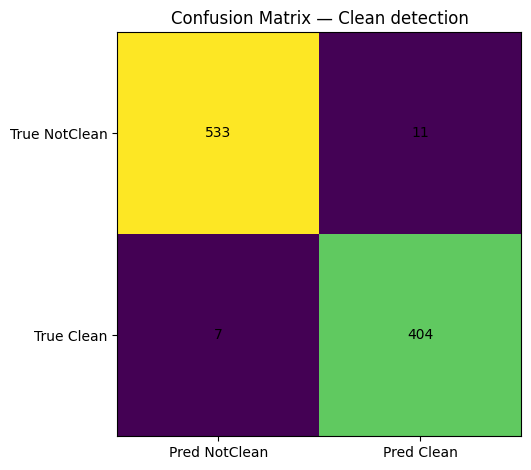

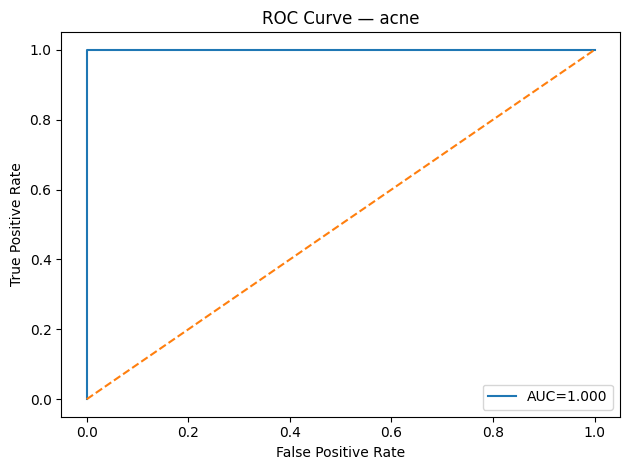

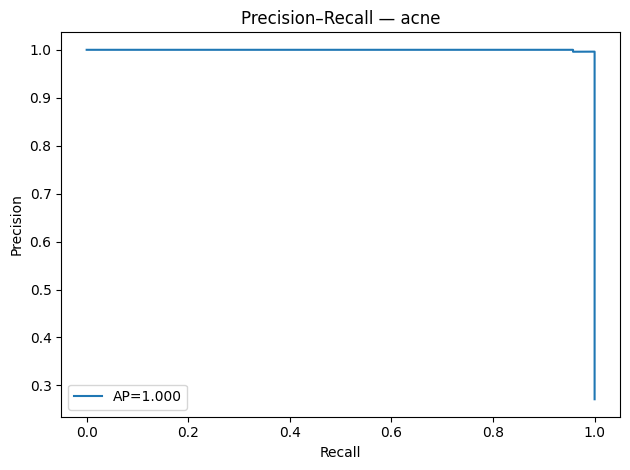

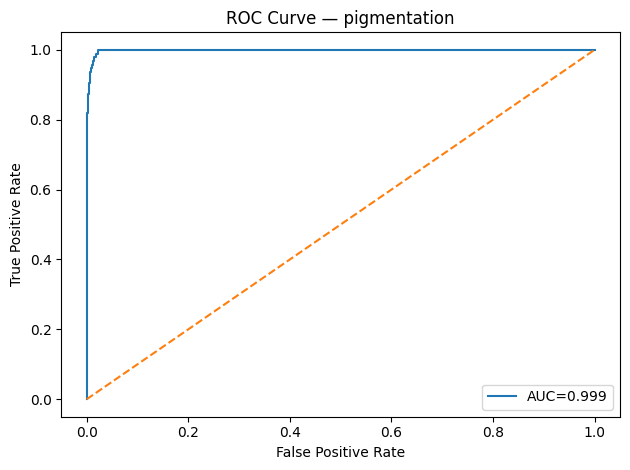

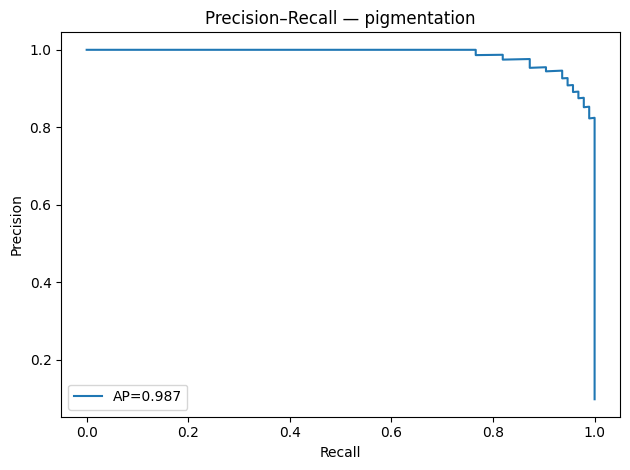

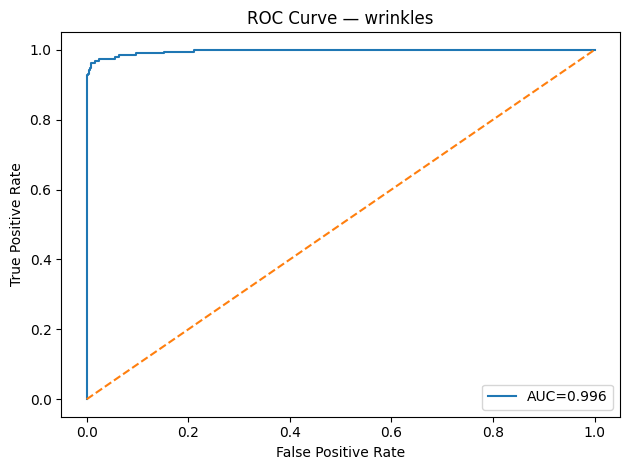

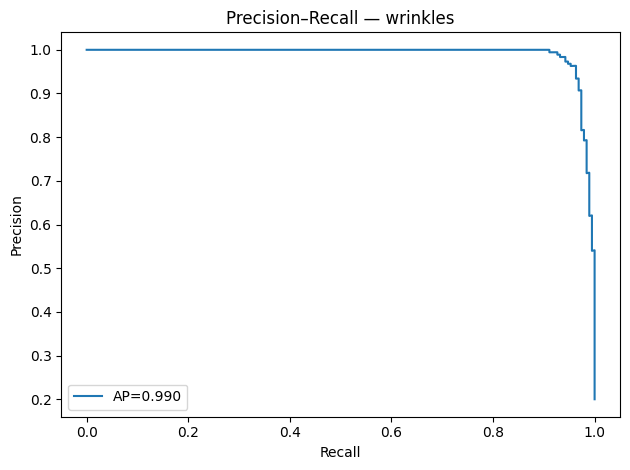

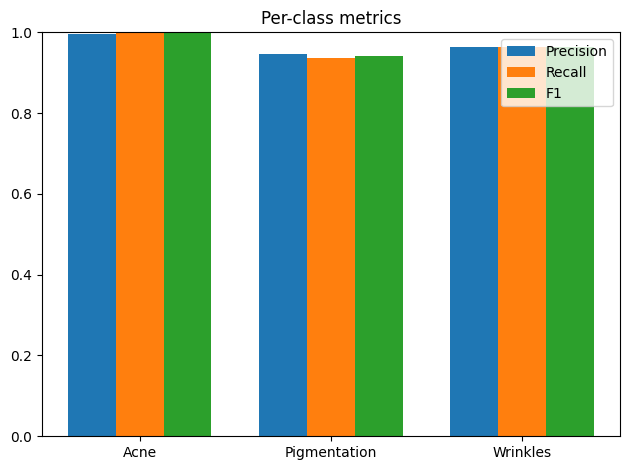

In [ ]:
# CELL RPT_inline — show full evaluation + plots inline (no files saved)

import os, json, numpy as np, pandas as pd, matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import (
    classification_report, multilabel_confusion_matrix, confusion_matrix,
    accuracy_score, roc_curve, auc, precision_recall_curve,
    average_precision_score, f1_score
)

# --- paths (edit DRIVE_DIR only if your folder name differs) ---
DRIVE_DIR   = "/content/drive/MyDrive/acne clean pigmentation wrinkles"
MODEL_PATH  = os.path.join(DRIVE_DIR, "skin_3label.keras")
VAL_CSV     = os.path.join(DRIVE_DIR, "val_split_dedup.csv")
THR_JSON    = os.path.join(DRIVE_DIR, "models", "thresholds.json")  # optional

CLASSES  = ["acne","pigmentation","wrinkles"]
IMG_SIZE = (224,224); BATCH = 32

# --- load model (works even if trained with custom loss) ---
def _dummy_loss(y_true, y_pred):
    return tf.keras.backend.binary_crossentropy(y_true, y_pred)
try:
    model = tf.keras.models.load_model(MODEL_PATH, custom_objects={"weighted_bce": _dummy_loss})
except Exception:
    model = tf.keras.models.load_model(MODEL_PATH)

# --- build val dataset ---
val_df = pd.read_csv(VAL_CSV)
val_df = val_df[val_df["filepath"].apply(lambda p: tf.io.gfile.exists(str(p)))].reset_index(drop=True)

def _load_row(path, labels):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    return img, tf.cast(labels, tf.float32)

def _df_to_ds(frame):
    paths  = frame["filepath"].astype(str).values
    labels = frame[CLASSES].values.astype("float32")
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(lambda p,l: _load_row(p,l), num_parallel_calls=tf.data.AUTOTUNE)
    return ds.batch(BATCH).prefetch(tf.data.AUTOTUNE)

val_ds = _df_to_ds(val_df)

# --- collect probabilities on VAL ---
y_true, y_prob, filepaths = [], [], []
for (x, y), fp in zip(val_ds, np.array_split(val_df["filepath"].values, len(val_ds))):
    y_true.append(y.numpy())
    y_prob.append(model.predict(x, verbose=0))
    filepaths.extend(fp.tolist())
y_true = np.vstack(y_true); y_prob = np.vstack(y_prob)

# --- thresholds: load if present, else auto-tune for max F1 on VAL ---
if os.path.exists(THR_JSON):
    with open(THR_JSON) as f: best_thr = json.load(f)
    thr = np.array([best_thr.get(c, 0.5) for c in CLASSES], dtype="float32")
else:
    thr = np.zeros(len(CLASSES), dtype="float32")
    for i, c in enumerate(CLASSES):
        ts = np.linspace(0.2, 0.8, 241)
        f1s = [f1_score(y_true[:,i], (y_prob[:,i] >= t).astype(int)) for t in ts]
        thr[i] = float(ts[int(np.argmax(f1s))])

y_pred = (y_prob >= thr).astype(int)

# --- derived "clean" label & exact-match accuracy (subset accuracy) ---
y_true_clean = (y_true.sum(axis=1) == 0).astype(int)
y_pred_clean = (y_pred.sum(axis=1) == 0).astype(int)
exact_match_acc = accuracy_score(                                   # subset accuracy for multilabel
    np.hstack([y_true, y_true_clean.reshape(-1,1)]),
    np.hstack([y_pred, y_pred_clean.reshape(-1,1)])
)

# --- print text blocks like your screenshot ---
print("=== Per-Label Classification Report ===")
rep = classification_report(y_true, y_pred, target_names=CLASSES, output_dict=True)
print(pd.DataFrame(rep).T.round(3))

print("\n=== Clean-Face Detection Report ===")
clean_rep = classification_report(y_true_clean, y_pred_clean, target_names=["Not Clean","Clean"], output_dict=True)
print(pd.DataFrame(clean_rep).T.round(3))

print(f"\n🔴 Exact Match Accuracy (all 4 labels): {exact_match_acc*100:.2f}%")
print("Thresholds used:", {c: round(float(thr[i]),3) for i,c in enumerate(CLASSES)})

# --- show confusion matrices per class ---
for i, c in enumerate(CLASSES):
    cm = confusion_matrix(y_true[:,i], y_pred[:,i], labels=[0,1])
    fig = plt.figure()
    plt.imshow(cm, interpolation='nearest')
    plt.title(f"Confusion Matrix — {c}")
    plt.xticks([0,1], ['Pred 0','Pred 1']); plt.yticks([0,1], ['True 0','True 1'])
    for (r, col), val in np.ndenumerate(cm): plt.text(col, r, int(val), ha='center', va='center')
    plt.tight_layout(); plt.show()

# clean vs not-clean matrix
cm_clean = confusion_matrix(y_true_clean, y_pred_clean, labels=[0,1])
fig = plt.figure()
plt.imshow(cm_clean, interpolation='nearest')
plt.title("Confusion Matrix — Clean detection")
plt.xticks([0,1], ['Pred NotClean','Pred Clean']); plt.yticks([0,1], ['True NotClean','True Clean'])
for (r, col), val in np.ndenumerate(cm_clean): plt.text(col, r, int(val), ha='center', va='center')
plt.tight_layout(); plt.show()

# --- ROC & PR curves per class (shown inline) ---
for i, c in enumerate(CLASSES):
    # ROC
    fpr, tpr, _ = roc_curve(y_true[:,i], y_prob[:,i])
    roc_auc = auc(fpr, tpr)
    fig = plt.figure()
    plt.plot(fpr, tpr, label=f"AUC={roc_auc:.3f}")
    plt.plot([0,1], [0,1], linestyle='--')
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve — {c}"); plt.legend(); plt.tight_layout(); plt.show()

    # PR
    P, R, _ = precision_recall_curve(y_true[:,i], y_prob[:,i])
    ap = average_precision_score(y_true[:,i], y_prob[:,i])
    fig = plt.figure()
    plt.plot(R, P, label=f"AP={ap:.3f}")
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title(f"Precision–Recall — {c}"); plt.legend(); plt.tight_layout(); plt.show()

# --- bar chart of per-class P/R/F1 ---
prec = [rep[c]["precision"] for c in CLASSES]
rec  = [rep[c]["recall"] for c in CLASSES]
f1   = [rep[c]["f1-score"] for c in CLASSES]
fig = plt.figure(); x = np.arange(len(CLASSES)); w = 0.25
plt.bar(x-w, prec, width=w, label="Precision")
plt.bar(x,     rec,  width=w, label="Recall")
plt.bar(x+w,   f1,   width=w, label="F1")
plt.xticks(x, [c.title() for c in CLASSES])
plt.ylim(0,1.0); plt.title("Per-class metrics"); plt.legend(); plt.tight_layout(); plt.show()


Confusion matrix (counts):
 [[256   3   0   0]
 [  1  92   1   0]
 [  0   4 185   2]
 [  0   1  27 383]]


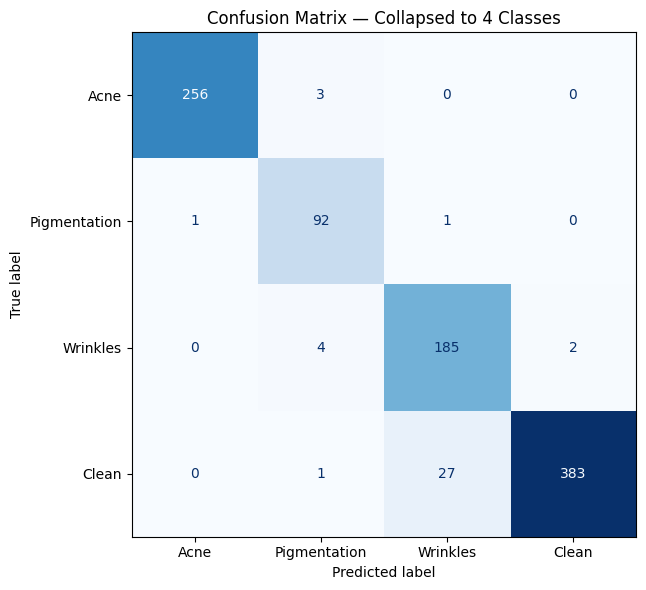

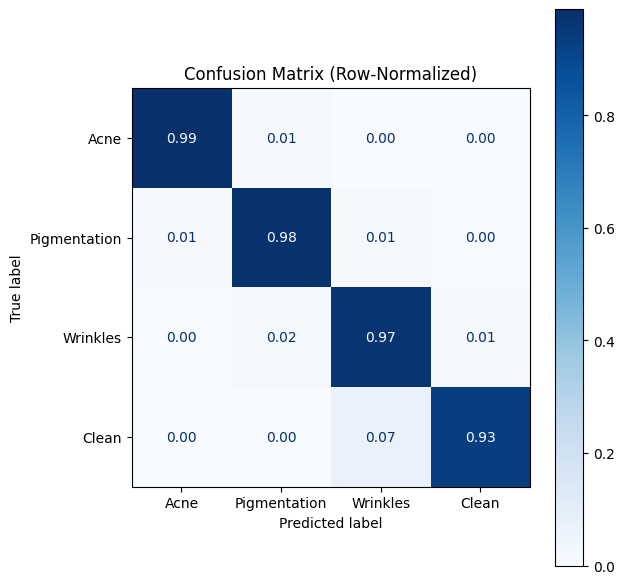

In [ ]:
# CELL CM4 — 4x4 confusion matrix for Acne / Pigmentation / Wrinkles / Clean (collapsed from multilabel)

import os, json, numpy as np, pandas as pd, matplotlib.pyplot as plt, tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay  # visualization helper

# ---- paths (edit only DRIVE_DIR if different) ----
DRIVE_DIR  = "/content/drive/MyDrive/acne clean pigmentation wrinkles"
MODEL_PATH = os.path.join(DRIVE_DIR, "skin_3label.keras")
VAL_CSV    = os.path.join(DRIVE_DIR, "val_split_dedup.csv")
THR_JSON   = os.path.join(DRIVE_DIR, "models", "thresholds.json")  # optional (from threshold-tuning cell)

CLASSES   = ["acne","pigmentation","wrinkles"]
LABELS_4  = ["Acne","Pigmentation","Wrinkles","Clean"]  # display order
IMG_SIZE  = (224,224)
BATCH     = 32

# --- load model (works even if trained with a custom loss) ---
def _dummy_loss(y_true, y_pred):  # not used at inference; just for loading
    return tf.keras.backend.binary_crossentropy(y_true, y_pred)
try:
    model = tf.keras.models.load_model(MODEL_PATH, custom_objects={"weighted_bce": _dummy_loss})
except Exception:
    model = tf.keras.models.load_model(MODEL_PATH)

# --- validation dataset ---
val_df = pd.read_csv(VAL_CSV)
val_df = val_df[val_df["filepath"].apply(lambda p: tf.io.gfile.exists(str(p)))].reset_index(drop=True)

def _load_row(path, labels):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    return img, tf.cast(labels, tf.float32)

def _df_to_ds(frame):
    paths  = frame["filepath"].astype(str).values
    labels = frame[CLASSES].values.astype("float32")
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(lambda p,l: _load_row(p,l), num_parallel_calls=tf.data.AUTOTUNE)
    return ds.batch(BATCH).prefetch(tf.data.AUTOTUNE)

val_ds = _df_to_ds(val_df)

# --- collect probabilities and truths ---
y_true_list, y_prob_list = [], []
for x, y in val_ds:
    y_true_list.append(y.numpy())
    y_prob_list.append(model.predict(x, verbose=0))
y_true = np.vstack(y_true_list)     # shape: [N, 3]
y_prob = np.vstack(y_prob_list)     # shape: [N, 3]

# --- thresholds: load tuned ones if present; else default 0.5 ---
if os.path.exists(THR_JSON):
    with open(THR_JSON) as f:
        thr_map = json.load(f)
    thr = np.array([thr_map.get(c, 0.5) for c in CLASSES], dtype="float32")
else:
    thr = np.array([0.5, 0.5, 0.5], dtype="float32")

y_pred_bin = (y_prob >= thr).astype(int)

# --- collapse MULTILABEL -> single class (index 0..3) ---
# rule: if no positives -> Clean(3); else choose positive class with highest probability
def collapse_true(row):
    # if multiple truths, pick the first one according to this priority (edit as you like)
    # priority = Acne(0) > Pigmentation(1) > Wrinkles(2)
    if row.sum() == 0: return 3
    for idx in [0,1,2]:
        if row[idx] == 1: return idx
    return 3

def collapse_pred(probs, preds):
    if preds.sum() == 0:  # predicted no issues
        return 3
    # among predicted positives, take the one with highest probability
    pos_idx = np.where(preds == 1)[0]
    best = pos_idx[np.argmax(probs[pos_idx])]
    return int(best)

y_true_single = np.array([collapse_true(r) for r in y_true], dtype=int)
y_pred_single = np.array([collapse_pred(p, r) for p, r in zip(y_prob, y_pred_bin)], dtype=int)

# --- build confusion matrix (absolute counts) ---
cm = confusion_matrix(y_true_single, y_pred_single, labels=[0,1,2,3])  # Acne,Pig,Wrinkles,Clean
print("Confusion matrix (counts):\n", cm)

# --- plot pretty (counts) ---
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LABELS_4)
fig, ax = plt.subplots(figsize=(6.5, 6))
disp.plot(ax=ax, values_format='d', cmap='Blues', colorbar=False)
ax.set_title("Confusion Matrix — Collapsed to 4 Classes")
plt.tight_layout()
plt.show()

# --- also show row-normalized version (percentages) ---
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=LABELS_4)
fig, ax = plt.subplots(figsize=(6.5, 6))
disp2.plot(ax=ax, values_format='.2f', cmap='Blues', colorbar=True)
ax.set_title("Confusion Matrix (Row-Normalized)")
plt.tight_layout()
plt.show()


In [ ]:
# PATCH: classify_image without .numpy()
import numpy as np
import tensorflow as tf

def classify_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, (224, 224))
    img = tf.cast(img, tf.float32) / 255.0

    # predict() -> NumPy array; no .numpy() here
    probs = cls_model.predict(tf.expand_dims(img, 0), verbose=0)[0]
    probs = np.asarray(probs, dtype=np.float32)  # ensure ndarray

    return {c: float(probs[i]) for i, c in enumerate(CLASSES)}


In [ ]:
# CELL: LOAD MODELS (run once per session)

# --- imports / install ultralytics if needed ---
import os, json, base64, io, numpy as np, tensorflow as tf
from PIL import Image, ImageDraw
from IPython.display import display, HTML
try:
    from ultralytics import YOLO
except Exception:
    !pip -q install -U ultralytics
    from ultralytics import YOLO

# --- paths / thresholds (edit if needed) ---
DRIVE_DIR  = "/content/drive/MyDrive/acne clean pigmentation wrinkles"
CLS_PATH   = f"{DRIVE_DIR}/skin_3label.keras"
DC_WEIGHTS = "/content/drive/MyDrive/dark circles/results/run_20250809_151352/weights/best.pt"  # <- your .pt
THR        = {"acne":0.5, "pigmentation":0.5, "wrinkles":0.5, "dark_circles":0.45}

CLASSES  = ["acne","pigmentation","wrinkles"]
IMG_SIZE = (224,224)

# --- load classifier (handles custom loss name if present) ---
def _dummy_loss(y_true, y_pred):
    return tf.keras.backend.binary_crossentropy(y_true, y_pred)

try:
    cls_model = tf.keras.models.load_model(CLS_PATH, custom_objects={"weighted_bce": _dummy_loss})
except Exception:
    cls_model = tf.keras.models.load_model(CLS_PATH)

# --- load YOLO dark-circles model ---
assert os.path.exists(DC_WEIGHTS), f"YOLO weights not found at: {DC_WEIGHTS}"
yolo_dc = YOLO(DC_WEIGHTS)

# --- helpers used by your inference cell ---
def classify_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    probs = cls_model.predict(tf.expand_dims(img,0), verbose=0)[0]  # NumPy already
    # booleans only (no probabilities)
    return {c: bool(probs[i] >= THR[c]) for i, c in enumerate(CLASSES)}

def yolo_dark_circles(path, conf_thr=0.30, iou_thr=0.5):
    res = yolo_dc.predict(path, imgsz=640, conf=conf_thr, iou=iou_thr, verbose=False)[0]
    boxes = []
    names = getattr(yolo_dc, "names", {})
    for b in res.boxes:
        c = int(b.cls); conf = float(b.conf)
        name = (names.get(c, str(c)) or "").lower()
        if (len(names) <= 1 or "dark" in name) and conf >= THR["dark_circles"]:
            x1,y1,x2,y2 = [int(v) for v in b.xyxy[0].cpu().numpy().tolist()]
            boxes.append(((x1,y1,x2,y2), conf))
    pil = Image.open(path).convert("RGB")
    draw = ImageDraw.Draw(pil)
    for (x1,y1,x2,y2), _ in boxes:
        draw.rectangle([x1,y1,x2,y2], outline=(255,0,0), width=3)
    return pil, (len(boxes) > 0)

def pil_to_data_uri(img):
    buf = io.BytesIO(); img.save(buf, format="JPEG", quality=92)
    return "data:image/jpeg;base64," + base64.b64encode(buf.getvalue()).decode()

def render_card(filename, acne, pigment, wrinkles, dark_circles, img_uri):
    def badge(label, ok, true_text="True", false_text="False"):
        color = "#10B981" if ok else "#6B7280"
        text  = true_text if ok else false_text
        icon  = "✓" if ok else "✕"
        return f'''
          <div class="badge" style="background:{color}1A;border:1px solid {color};color:{color}">
            <span class="dot" style="background:{color}"></span>
            <span class="label">{label}</span>
            <span class="value">{icon} {text}</span>
          </div>'''
    dc_badge = badge("Dark circles", dark_circles, "Detected", "Not detected")
    html = f"""
    <style>
      .card {{display:flex; gap:18px; align-items:flex-start; background:#fff;border:1px solid #e5e7eb;border-radius:16px;padding:16px;box-shadow:0 6px 18px rgba(0,0,0,.06);font-family:Inter,system-ui,Segoe UI,Roboto,Arial,sans-serif}}
      .left img {{border-radius:12px; max-width:480px; height:auto; display:block}}
      .right {{min-width:280px}}
      .title {{font-weight:700; font-size:16px; margin:2px 0 10px 0; color:#111827}}
      .grid {{display:grid; grid-template-columns:1fr; gap:10px}}
      .badge {{display:flex; align-items:center; gap:10px; padding:10px 12px; border-radius:12px; font-weight:600}}
      .badge .dot {{width:8px; height:8px; border-radius:50%; display:inline-block}}
      .label {{flex:1; opacity:.9}}
      .value {{font-variant-numeric: tabular-nums}}
      .section {{font-size:12px; text-transform:uppercase; letter-spacing:.12em; color:#6B7280; margin:16px 0 8px}}
    </style>
    """
    html += f"""
    <div class="card">
      <div class="left"><img src="{img_uri}" /></div>
      <div class="right">
        <div class="title">{filename}</div>
        <div class="section">Findings</div>
        <div class="grid">
          {badge("Acne", acne)}
          {badge("Pigmentation", pigment)}
          {badge("Wrinkles", wrinkles)}
          {dc_badge}
        </div>
      </div>
    </div>"""
    display(HTML(html))

print("✅ Models loaded.")
print("   Classifier:", CLS_PATH)
print("   YOLO:", DC_WEIGHTS)
print("   Thresholds:", THR)


✅ Models loaded.
   Classifier: /content/drive/MyDrive/acne clean pigmentation wrinkles/skin_3label.keras
   YOLO: /content/drive/MyDrive/dark circles/results/run_20250809_151352/weights/best.pt
   Thresholds: {'acne': 0.5, 'pigmentation': 0.5, 'wrinkles': 0.5, 'dark_circles': 0.45}


In [ ]:
# ONE-CELL • Fancy boolean output for classifier + dark circles (no probabilities)

# --- EDIT THESE if needed ---
DRIVE_DIR  = "/content/drive/MyDrive/acne clean pigmentation wrinkles"
CLS_PATH   = f"{DRIVE_DIR}/skin_3label.keras"
DC_WEIGHTS = "/content/drive/MyDrive/dark circles/results/run_20250809_151352/weights/best.pt"  # <- put your .pt here
THR        = {"acne":0.5, "pigmentation":0.5, "wrinkles":0.5, "dark_circles":0.45}

# --- Imports (ultralytics may already be installed) ---
import os, json, base64, io, numpy as np, tensorflow as tf, matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from google.colab import files
from IPython.display import display, HTML  # pretty HTML in Colab
try:
    from ultralytics import YOLO
except Exception:
    !pip -q install -U ultralytics
    from ultralytics import YOLO

# --- Load models ---
def _dummy_loss(y_true, y_pred):  # only needed if the model was saved with a custom loss name
    return tf.keras.backend.binary_crossentropy(y_true, y_pred)

if 'cls_model' not in globals():
    try:
        cls_model = tf.keras.models.load_model(CLS_PATH, custom_objects={"weighted_bce": _dummy_loss})
    except Exception:
        cls_model = tf.keras.models.load_model(CLS_PATH)

assert os.path.exists(DC_WEIGHTS), f"YOLO weights not found at: {DC_WEIGHTS}"
yolo_dc = YOLO(DC_WEIGHTS)

CLASSES  = ["acne","pigmentation","wrinkles"]
IMG_SIZE = (224,224)

# --- Helpers ---
def classify_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    probs = cls_model.predict(tf.expand_dims(img,0), verbose=0)[0]  # NumPy already
    # booleans only
    return {c: bool(probs[i] >= THR[c]) for i, c in enumerate(CLASSES)}

def yolo_dark_circles(path, conf_thr=0.30, iou_thr=0.5):
    res = yolo_dc.predict(path, imgsz=640, conf=conf_thr, iou=iou_thr, verbose=False)[0]
    boxes = []
    names = yolo_dc.names if hasattr(yolo_dc, "names") else {}
    for b in res.boxes:
        c = int(b.cls); conf = float(b.conf)
        name = (names.get(c, str(c)) or "").lower()
        if (len(names) <= 1 or "dark" in name) and conf >= THR["dark_circles"]:
            x1,y1,x2,y2 = [int(v) for v in b.xyxy[0].cpu().numpy().tolist()]
            boxes.append(((x1,y1,x2,y2), conf))
    pil = Image.open(path).convert("RGB")
    draw = ImageDraw.Draw(pil)
    for (x1,y1,x2,y2), _ in boxes:
        draw.rectangle([x1,y1,x2,y2], outline=(255,0,0), width=3)
    return pil, (len(boxes) > 0)

def pil_to_data_uri(img):
    buf = io.BytesIO()
    img.save(buf, format="JPEG", quality=92)
    return "data:image/jpeg;base64," + base64.b64encode(buf.getvalue()).decode()

def render_card(filename, acne, pigment, wrinkles, dark_circles, img_uri):
    def badge(label, ok, true_text="True", false_text="False"):
        color = "#10B981" if ok else "#6B7280"  # teal or gray
        text  = true_text if ok else false_text
        icon  = "✓" if ok else "✕"
        return f'''
          <div class="badge" style="background:{color}1A;border:1px solid {color};color:{color}">
            <span class="dot" style="background:{color}"></span>
            <span class="label">{label}</span>
            <span class="value">{icon} {text}</span>
          </div>'''
    dc_badge = badge("Dark circles", dark_circles, "Detected", "Not detected")
    html = f"""
    <style>
      .card {{
        display:flex; gap:18px; align-items:flex-start;
        background: radial-gradient(1200px 600px at -10% -20%, #eef7ff, transparent), #fff;
        border:1px solid #e5e7eb; border-radius:16px; padding:16px; box-shadow:0 6px 18px rgba(0,0,0,.06);
        font-family: Inter, system-ui, -apple-system, Segoe UI, Roboto, Arial, sans-serif;
      }}
      .left img {{ border-radius:12px; max-width:480px; height:auto; display:block; }}
      .right {{ min-width:280px; }}
      .title {{ font-weight:700; font-size:16px; margin:2px 0 10px 0; color:#111827; }}
      .grid {{ display:grid; grid-template-columns:1fr; gap:10px; }}
      .badge {{
        display:flex; align-items:center; gap:10px; padding:10px 12px; border-radius:12px; font-weight:600;
      }}
      .badge .dot {{ width:8px; height:8px; border-radius:50%; display:inline-block; }}
      .label {{ flex:1; opacity:.9 }}
      .value {{ font-variant-numeric: tabular-nums }}
      .section {{ font-size:12px; text-transform:uppercase; letter-spacing:.12em; color:#6B7280; margin:16px 0 8px }}
    </style>
    <div class="card">
      <div class="left">
        <img src="{img_uri}" alt="result"/>
      </div>
      <div class="right">
        <div class="title">{filename}</div>
        <div class="section">Findings</div>
        <div class="grid">
          {badge("Acne", acne)}
          {badge("Pigmentation", pigment)}
          {badge("Wrinkles", wrinkles)}
          {dc_badge}
        </div>
      </div>
    </div>
    """
    display(HTML(html))  # pretty inline output in Colab/Jupyter
    # (Using IPython.display.HTML to render styled cards.)  # docs: https://ipython.readthedocs.io/

# --- Pick images from your PC and show fancy results (booleans only) ---
uploaded = files.upload()  # opens the local file picker in Colab
for fname in uploaded.keys():
    path = os.path.abspath(fname)
    # classifier booleans
    flags = classify_image(path)  # {'acne': bool, 'pigmentation': bool, 'wrinkles': bool}
    # YOLO dark circles + annotated image
    vis_pil, dc_found = yolo_dark_circles(path)
    # Render pretty card (no probabilities)
    render_card(
        filename=os.path.basename(path),
        acne=flags["acne"],
        pigment=flags["pigmentation"],
        wrinkles=flags["wrinkles"],
        dark_circles=dc_found,
        img_uri=pil_to_data_uri(vis_pil)
    )

In [ ]:
# HOTFIX: avoid tf.data path inside model.predict()
import numpy as np, tensorflow as tf

def batched_predict_eager(model, paths, batch_size=32):
    outs = []
    for i in range(0, len(paths), batch_size):
        batch_paths = paths[i:i+batch_size]
        batch_imgs  = tf.stack([preprocess_img(p) for p in batch_paths], axis=0)
        y = model(batch_imgs, training=False)              # direct eager call
        y = y.numpy() if hasattr(y, "numpy") else np.array(y)
        outs.append(y)
    return np.concatenate(outs, axis=0)

# OPTIONAL (only if you still see graph/predict errors):
# tf.config.run_functions_eagerly(True)

print("Eager mode:", tf.executing_eagerly())
print("✓ Patched: use batched_predict_eager(...) instead of batched_predict(...).")


Eager mode: True
✓ Patched: use batched_predict_eager(...) instead of batched_predict(...).


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[OK] Output directory: /content/drive/MyDrive/SkinReport_Chapter4
GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[*] Loading classifier…


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'loss_scale_optimizer', because it has 10 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 6 variables whereas the saved optimizer has 0 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


[OK] Classifier loaded.
[*] Reading labels…
[OK] No split column. Using all rows as Test: N=5062
[OK] Saved Table 4.1 -> /content/drive/MyDrive/SkinReport_Chapter4/Table_4_1_Dataset_Summary.csv


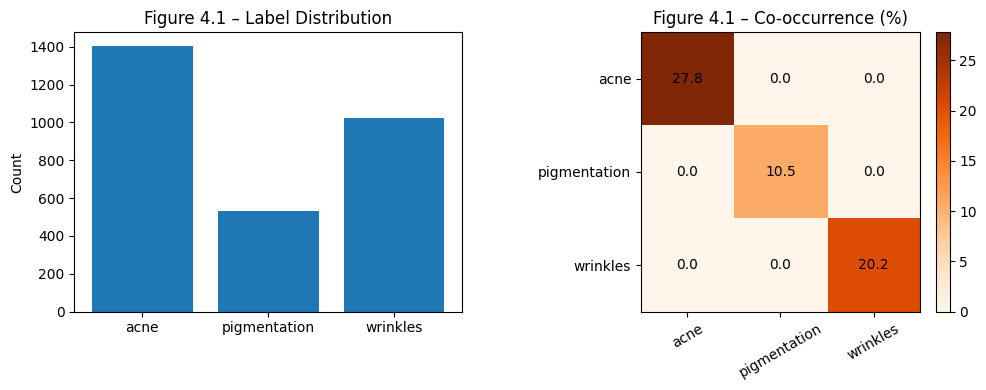

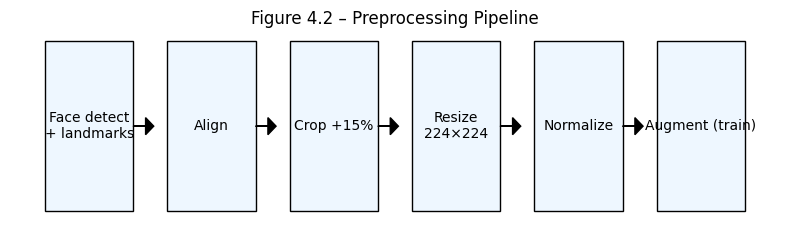

[*] Resolving image paths for classifier test set…
[*] Predicting probabilities (eager)…


Scoring:   0%|          | 0/159 [00:00<?, ?it/s]

[OK] Saved Table 4.2 -> /content/drive/MyDrive/SkinReport_Chapter4/Table_4_2_Classifier_Test_Metrics.csv


,Label,Precision,Recall,F1,ROC-AUC,PR-AUC
0,acne,0.962938,0.997866,0.980091,0.999869,0.999668
1,pigmentation,0.833856,0.996255,0.907850,0.999001,0.991372
2,wrinkles,0.864957,0.990215,0.923358,0.998364,0.995614
3,Macro avg,0.887250,0.994779,0.937099,0.999078,0.995551
4,Micro avg,0.902603,0.994936,0.946523,NaN,NaN


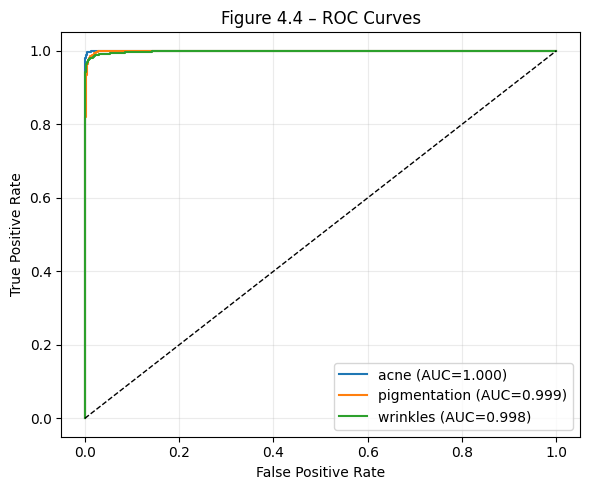

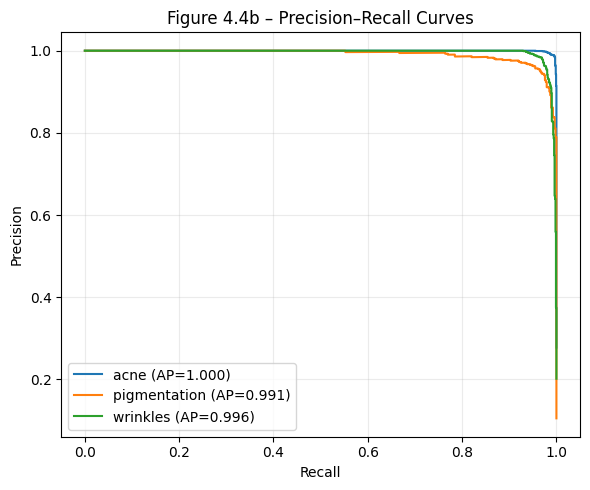

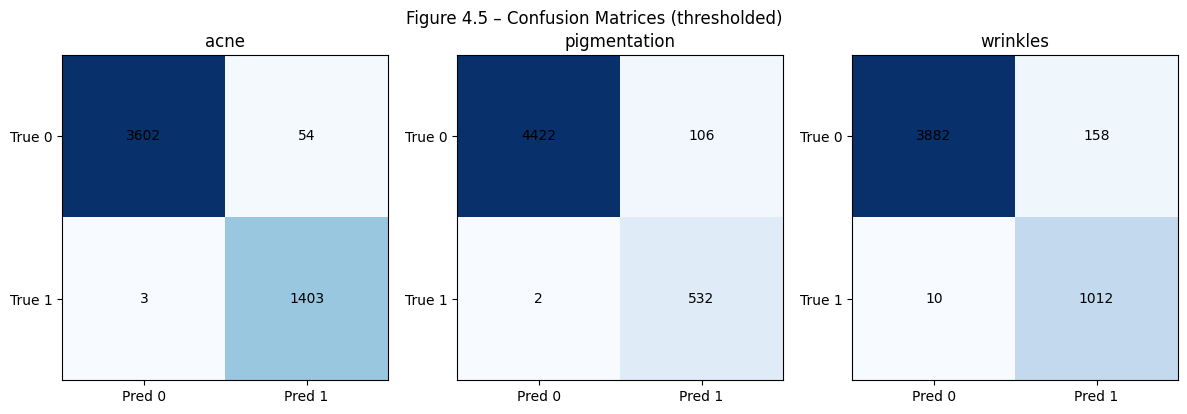

[INFO] No training history file found. Skipping Figure 4.3.
[*] YOLO setup…
[OK] YOLO loaded.
[YOLO] Running val() on: /content/drive/MyDrive/dark circles/train/images (split 'test' or fallback to 'val')
Ultralytics 8.3.190 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
[YOLO] Skipping mAP (val() failed safely): val: Error loading data from None
See https://docs.ultralytics.com/datasets for dataset formatting guidance.
[OK] Saved Figure 4.7 -> /content/drive/MyDrive/SkinReport_Chapter4/Figure_4_7_YOLO_Examples.png


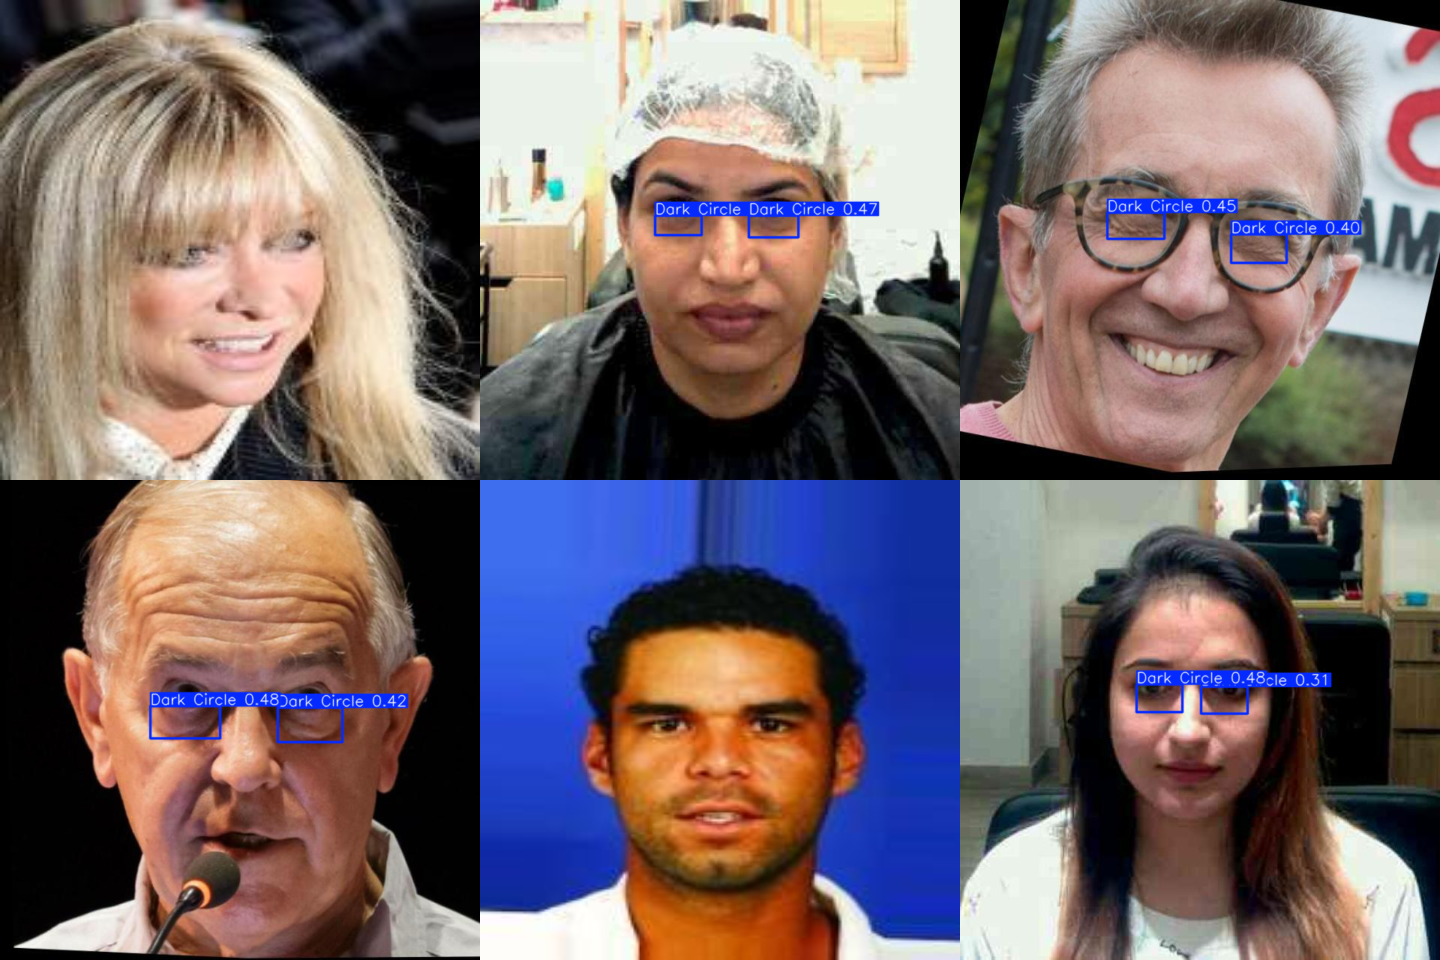


=== DONE ===
All figures/tables saved under: /content/drive/MyDrive/SkinReport_Chapter4
If you want YOLO mAP but YAML lacks paths, set DC_IMAGES_DIR_FALLBACK to a folder with images.


In [ ]:
# ONE-CELL: Chapter 4 assets generator (Classifier: acne/pigmentation/wrinkles, YOLO: dark circles)
# - Loads your saved models from Drive
# - Produces all figures/tables used in the report and saves them to Google Drive
# - Robust to Ultralytics data.yaml missing/None split paths

# =====================
# CONFIG — EDIT THESE
# =====================
MOUNT_DRIVE           = True
OUT_DIR               = "/content/drive/MyDrive/SkinReport_Chapter4"  # where outputs go

# --- Classifier (3-label) ---
CLS_MODEL_PATH        = "/content/drive/MyDrive/acne clean pigmentation wrinkles/skin_3label.keras"
CLS_DATA_DIR          = "/content/drive/MyDrive/acne clean pigmentation wrinkles"   # root containing images + labels.csv
CLS_LABELS_CSV        = f"{CLS_DATA_DIR}/labels.csv"                                # must have: filename, acne, pigmentation, wrinkles
CLS_OPTIONAL_TEST_CSV = None                                                        # optional separate CSV; else uses labels.csv
SPLIT_COL             = "split"                                                     # if present, rows with 'Test' used; else all rows

# Image preprocessing for classifier
IMG_SIZE              = (224, 224)
USE_MEAN_STD          = False
NORM_MEAN             = [0.485, 0.456, 0.406]
NORM_STD              = [0.229, 0.224, 0.225]

# Decision thresholds (for confusion matrices only; ROC/PR ignore)
THR = {"acne": 0.5, "pigmentation": 0.5, "wrinkles": 0.5}

# Optional Keras history files
CLS_HISTORY_CANDIDATES = [
    CLS_MODEL_PATH.replace(".keras", "_history.json"),
    CLS_MODEL_PATH.replace(".keras", "_history.npy"),
    CLS_MODEL_PATH.replace(".keras", "_history.pkl"),
]

# --- YOLO (dark circles) ---
DC_WEIGHTS            = "/content/drive/MyDrive/dark circles/results/run_20250809_151352/weights/best.pt"
DC_DATA_YAML          = "/content/drive/MyDrive/dark circles/data.yaml"  # Ultralytics YAML
YOLO_IMGSZ            = 640
YOLO_VAL_SPLIT        = "test"  # try "test" first, otherwise will fall back to "val" if available
N_EXAMPLE_DETS        = 6       # images for montage grid
# If YAML is missing real paths, you can point this to a folder with images to use for the montage:
DC_IMAGES_DIR_FALLBACK = None    # e.g., "/content/drive/MyDrive/dark circles/images/test"

# =====================
# Imports
# =====================
import os, io, json, glob, math, random, pickle, yaml, csv, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image
from sklearn.metrics import (
    roc_curve, auc, precision_recall_curve, average_precision_score,
    confusion_matrix, precision_recall_fscore_support
)

import tensorflow as tf
from tensorflow import keras

try:
    from ultralytics import YOLO
except Exception:
    !pip -q install -U ultralytics
    from ultralytics import YOLO

try:
    from tqdm.auto import tqdm
except Exception:
    !pip -q install -U tqdm
    from tqdm.auto import tqdm

if MOUNT_DRIVE:
    from google.colab import drive
    drive.mount('/content/drive')

os.makedirs(OUT_DIR, exist_ok=True)
print(f"[OK] Output directory: {OUT_DIR}")
print("GPU devices:", tf.config.list_physical_devices('GPU'))

# =====================
# Utils
# =====================
def resolve_image_path(filename, root):
    """Return absolute path for filename; supports absolute, relative, and basename lookup within root."""
    if os.path.isabs(filename) and os.path.exists(filename):
        return filename
    p1 = os.path.join(root, filename)
    if os.path.exists(p1):
        return p1
    base = os.path.basename(filename)
    for dirpath, _, files in os.walk(root):
        if base in files:
            return os.path.join(dirpath, base)
    raise FileNotFoundError(f"Image not found: {filename}")

def preprocess_img(path):
    """Load->resize->normalize consistent with training."""
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img.set_shape([None, None, 3])
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    if USE_MEAN_STD:
        mean = tf.constant(NORM_MEAN, dtype=img.dtype)
        std  = tf.constant(NORM_STD, dtype=img.dtype)
        img = (img - mean) / std
    return img

# Avoid model.predict() (some Colab/TF builds hit tf.data range_op issues)
def batched_predict_eager(model, paths, batch_size=32):
    outs = []
    total = max(1, math.ceil(len(paths) / max(1, batch_size)))
    for i in tqdm(range(0, len(paths), batch_size), total=total, desc="Scoring"):
        batch_paths = paths[i:i+batch_size]
        batch_imgs  = tf.stack([preprocess_img(p) for p in batch_paths], axis=0)
        y = model(batch_imgs, training=False)              # eager forward
        y = y.numpy() if hasattr(y, "numpy") else np.array(y)
        outs.append(y)
    return np.concatenate(outs, axis=0)

def draw_confusion_mats(y_true, y_pred_bin, class_names, savepath):
    fig, axes = plt.subplots(1, len(class_names), figsize=(4*len(class_names), 4))
    if len(class_names) == 1:
        axes = [axes]
    for i, c in enumerate(class_names):
        cm = confusion_matrix(y_true[:, i], y_pred_bin[:, i])
        ax = axes[i]
        ax.imshow(cm, cmap='Blues')
        ax.set_xticks([0,1]); ax.set_xticklabels(['Pred 0','Pred 1'])
        ax.set_yticks([0,1]); ax.set_yticklabels(['True 0','True 1'])
        ax.set_title(f"{c}")
        for (r, cc), val in np.ndenumerate(cm):
            ax.text(cc, r, str(val), ha='center', va='center', color='black')
    fig.suptitle("Figure 4.5 – Confusion Matrices (thresholded)")
    plt.tight_layout()
    fig.savefig(savepath, dpi=200, bbox_inches='tight')
    plt.show()

def plot_roc_pr(y_true, y_prob, class_names, out_roc, out_pr):
    # ROC
    fig = plt.figure(figsize=(6,5))
    for i, c in enumerate(class_names):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_prob[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{c} (AUC={roc_auc:.3f})")
    plt.plot([0,1], [0,1], 'k--', lw=1)
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title("Figure 4.4 – ROC Curves")
    plt.legend()
    plt.grid(alpha=.25)
    plt.tight_layout(); fig.savefig(out_roc, dpi=200); plt.show()

    # PR
    fig = plt.figure(figsize=(6,5))
    for i, c in enumerate(class_names):
        prec, rec, _ = precision_recall_curve(y_true[:, i], y_prob[:, i])
        ap = average_precision_score(y_true[:, i], y_prob[:, i])
        plt.plot(rec, prec, label=f"{c} (AP={ap:.3f})")
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title("Figure 4.4b – Precision–Recall Curves")
    plt.legend()
    plt.grid(alpha=.25)
    plt.tight_layout(); fig.savefig(out_pr, dpi=200); plt.show()

def plot_label_distribution_and_cooc(df, classes, outpath):
    fig, axes = plt.subplots(1, 2, figsize=(10,4))
    counts = [df[c].sum() for c in classes]
    axes[0].bar(classes, counts)
    axes[0].set_title("Figure 4.1 – Label Distribution"); axes[0].set_ylabel("Count")
    M = df[classes].values; N = len(df)
    cooc = (M.T @ M) / max(N,1) * 100.0
    im = axes[1].imshow(cooc, cmap='Oranges')
    axes[1].set_xticks(range(len(classes))); axes[1].set_xticklabels(classes, rotation=30)
    axes[1].set_yticks(range(len(classes))); axes[1].set_yticklabels(classes)
    axes[1].set_title("Figure 4.1 – Co-occurrence (%)")
    for (r,c), v in np.ndenumerate(cooc):
        axes[1].text(c, r, f"{v:.1f}", ha='center', va='center')
    fig.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)
    plt.tight_layout(); fig.savefig(outpath, dpi=200); plt.show()
    return counts, cooc

def try_load_history(paths):
    for p in paths:
        if os.path.exists(p):
            try:
                if p.endswith(".json"):
                    with open(p, 'r') as f: hist = json.load(f)
                elif p.endswith(".npy"):
                    hist = np.load(p, allow_pickle=True).item()
                else:
                    with open(p, 'rb') as f: hist = pickle.load(f)
                print(f"[OK] Loaded training history: {p}")
                return hist
            except Exception as e:
                print(f"[WARN] Failed to load history from {p}: {e}")
    return None

def plot_history(hist, savepath):
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    if "loss" in hist: ax[0].plot(hist["loss"], label="train loss")
    if "val_loss" in hist: ax[0].plot(hist["val_loss"], label="val loss")
    ax[0].set_title("Figure 4.3 – Training/Validation Loss"); ax[0].set_xlabel("Epoch"); ax[0].set_ylabel("Loss"); ax[0].legend(); ax[0].grid(alpha=.25)
    if "val_f1_macro" in hist or "f1_macro" in hist:
        if "f1_macro" in hist: ax[1].plot(hist["f1_macro"], label="train macro-F1")
        if "val_f1_macro" in hist: ax[1].plot(hist["val_f1_macro"], label="val macro-F1")
        ax[1].set_title("Figure 4.3 – Macro-F1"); ax[1].set_xlabel("Epoch"); ax[1].set_ylabel("F1"); ax[1].legend(); ax[1].grid(alpha=.25)
    else:
        ax[1].axis('off'); ax[1].text(0.5,0.5,"No F1 history logged", ha='center', va='center')
    plt.tight_layout(); fig.savefig(savepath, dpi=200); plt.show()

def draw_preprocess_diagram(savepath):
    plt.figure(figsize=(8,2.4))
    stages = ["Face detect\n+ landmarks", "Align", "Crop +15%", f"Resize\n{IMG_SIZE[0]}×{IMG_SIZE[1]}", "Normalize", "Augment (train)"]
    x = 0.5; ax = plt.gca()
    for i, s in enumerate(stages):
        ax.add_patch(Rectangle((x, 0.5), 1.3, 0.8, edgecolor='black', facecolor='#eef7ff'))
        plt.text(x+0.65, 0.9, s, ha='center', va='center')
        if i < len(stages)-1:
            plt.arrow(x+1.3, 0.9, 0.3, 0, head_width=0.08, length_includes_head=True, color='black')
        x += 1.8
    plt.axis('off'); plt.title("Figure 4.2 – Preprocessing Pipeline")
    plt.tight_layout(); plt.savefig(savepath, dpi=200); plt.show()

# =====================
# Load classifier
# =====================
print("[*] Loading classifier…")
def _dummy_loss(y_true, y_pred):  # for custom-object safety
    return tf.keras.backend.binary_crossentropy(y_true, y_pred)

try:
    cls_model = keras.models.load_model(CLS_MODEL_PATH, custom_objects={"weighted_bce": _dummy_loss})
except Exception:
    cls_model = keras.models.load_model(CLS_MODEL_PATH)
out_dim = cls_model.output_shape[-1]
assert out_dim == 3, f"Expected 3 outputs, got {out_dim}"
CLASS_NAMES = ["acne","pigmentation","wrinkles"]
print("[OK] Classifier loaded.")

# =====================
# Read labels & define test split
# =====================
print("[*] Reading labels…")
df_all = pd.read_csv(CLS_LABELS_CSV)
needed_cols = {"filename","acne","pigmentation","wrinkles"}
assert needed_cols.issubset(set(df_all.columns)), f"labels.csv must contain {needed_cols}"

# Optional test CSV override
if CLS_OPTIONAL_TEST_CSV and os.path.exists(CLS_OPTIONAL_TEST_CSV):
    df = pd.read_csv(CLS_OPTIONAL_TEST_CSV)
    print(f"[OK] Using explicit test CSV: {CLS_OPTIONAL_TEST_CSV} (N={len(df)})")
else:
    if SPLIT_COL in df_all.columns:
        mask = df_all[SPLIT_COL].astype(str).str.lower().eq("test")
        df = df_all[mask].copy()
        print(f"[OK] Using rows with split == 'Test': N={len(df)}")
    else:
        df = df_all.copy()
        print(f"[OK] No split column. Using all rows as Test: N={len(df)}")

# Dataset summary table (Table 4.1)
def dataset_summary(df_src, name="All"):
    row = {
        "Subset": name,
        "Images (clf)": len(df_src),
        "Acne=1": int(df_src["acne"].sum()),
        "Pigmentation=1": int(df_src["pigmentation"].sum()),
        "Wrinkles=1": int(df_src["wrinkles"].sum()),
    }
    return row

summary_rows = []
if SPLIT_COL in df_all.columns:
    for split_name in ["Train","Val","Validation","Test"]:
        m = df_all[SPLIT_COL].astype(str).str.lower().eq(split_name.lower())
        if m.any():
            summary_rows.append(dataset_summary(df_all[m], split_name.title()))
else:
    summary_rows.append(dataset_summary(df_all, "All"))

tbl41 = pd.DataFrame(summary_rows)
tbl41_path = os.path.join(OUT_DIR, "Table_4_1_Dataset_Summary.csv")
tbl41.to_csv(tbl41_path, index=False)
print(f"[OK] Saved Table 4.1 -> {tbl41_path}")

# Figure 4.1 – label distribution + co-occurrence
fig41_path = os.path.join(OUT_DIR, "Figure_4_1_Label_Distribution_and_Cooccurrence.png")
_ = plot_label_distribution_and_cooc(df_all, CLASS_NAMES, fig41_path)

# Figure 4.2 – preprocessing pipeline (simple diagram)
fig42_path = os.path.join(OUT_DIR, "Figure_4_2_Preprocessing_Pipeline.png")
draw_preprocess_diagram(fig42_path)

# =====================
# Evaluate classifier on test split
# =====================
print("[*] Resolving image paths for classifier test set…")
paths = [resolve_image_path(fn, CLS_DATA_DIR) for fn in df["filename"].tolist()]
y_true = df[CLASS_NAMES].astype(int).values

print("[*] Predicting probabilities (eager)…")
y_prob = batched_predict_eager(cls_model, paths, batch_size=32)

# Table 4.2 – P/R/F1 + AUCs
rows = []
for i, c in enumerate(CLASS_NAMES):
    y = y_true[:, i]; p = y_prob[:, i]
    yhat = (p >= THR[c]).astype(int)
    prec, rec, f1, _ = precision_recall_fscore_support(y, yhat, average='binary', zero_division=0)
    fpr, tpr, _ = roc_curve(y, p); roc_auc = auc(fpr, tpr)
    ap = average_precision_score(y, p)
    rows.append({"Label": c, "Precision": prec, "Recall": rec, "F1": f1, "ROC-AUC": roc_auc, "PR-AUC": ap})

prec_mi, rec_mi, f1_mi, _ = precision_recall_fscore_support(
    y_true.flatten(), (y_prob.flatten() >= 0.5).astype(int), average='binary', zero_division=0
)
macro = {"Label":"Macro avg",
         "Precision":np.mean([r["Precision"] for r in rows]),
         "Recall":np.mean([r["Recall"] for r in rows]),
         "F1":np.mean([r["F1"] for r in rows]),
         "ROC-AUC":np.mean([r["ROC-AUC"] for r in rows]),
         "PR-AUC":np.mean([r["PR-AUC"] for r in rows])}
micro = {"Label":"Micro avg","Precision":prec_mi,"Recall":rec_mi,"F1":f1_mi,"ROC-AUC":np.nan,"PR-AUC":np.nan}

tbl42 = pd.DataFrame(rows + [macro, micro])
tbl42_path = os.path.join(OUT_DIR, "Table_4_2_Classifier_Test_Metrics.csv")
tbl42.to_csv(tbl42_path, index=False)
print(f"[OK] Saved Table 4.2 -> {tbl42_path}")
display(tbl42)

# Figure 4.4 – ROC/PR
fig44_roc = os.path.join(OUT_DIR, "Figure_4_4_ROC.png")
fig44_pr  = os.path.join(OUT_DIR, "Figure_4_4b_PR.png")
plot_roc_pr(y_true, y_prob, CLASS_NAMES, fig44_roc, fig44_pr)

# Figure 4.5 – confusion matrices (at thresholds THR)
y_pred_bin = np.stack([(y_prob[:,i] >= THR[c]).astype(int) for i,c in enumerate(CLASS_NAMES)], axis=1)
fig45_path = os.path.join(OUT_DIR, "Figure_4_5_Confusion_Matrices.png")
draw_confusion_mats(y_true, y_pred_bin, CLASS_NAMES, fig45_path)

# =====================
# Training curves (optional)
# =====================
hist = try_load_history(CLS_HISTORY_CANDIDATES)
if hist is not None:
    fig43_path = os.path.join(OUT_DIR, "Figure_4_3_Training_Curves.png")
    plot_history(hist, fig43_path)
else:
    print("[INFO] No training history file found. Skipping Figure 4.3.")

# =====================
# YOLO – Dark Circles (robust to None paths in data.yaml)
# =====================
print("[*] YOLO setup…")
assert os.path.exists(DC_WEIGHTS), f"YOLO weights not found at: {DC_WEIGHTS}"
yolo_dc = YOLO(DC_WEIGHTS)
print("[OK] YOLO loaded.")

def read_yolo_sources(yaml_path, preferred_key="test"):
    """Return a list of existing sources (dirs/files) for a split in YAML, or [] if none."""
    if not os.path.exists(yaml_path):
        return []
    with open(yaml_path, 'r') as f:
        y = yaml.safe_load(f) or {}
    key = preferred_key if y.get(preferred_key) else ("val" if y.get("val") else None)
    if key is None:
        return []
    src = y.get(key)
    if src is None:
        return []
    if not isinstance(src, list):
        src = [src]
    out = []
    for p in src:
        if p is None:
            continue
        p = os.path.expanduser(str(p))
        if os.path.exists(p):
            out.append(p)
    return out

yolo_sources = read_yolo_sources(DC_DATA_YAML, YOLO_VAL_SPLIT)
if not yolo_sources and DC_IMAGES_DIR_FALLBACK and os.path.exists(DC_IMAGES_DIR_FALLBACK):
    print("[YOLO] YAML has no valid paths; using fallback images dir.")
    yolo_sources = [DC_IMAGES_DIR_FALLBACK]

def collect_images_from_sources(sources):
    """Return a flat list of image file paths from Ultralytics-style sources."""
    exts = (".jpg",".jpeg",".png",".bmp",".webp")
    pool = []
    for src in sources:
        if os.path.isdir(src):
            for dp,_,files in os.walk(src):
                for f in files:
                    if f.lower().endswith(exts):
                        pool.append(os.path.join(dp,f))
        elif os.path.isfile(src):
            if src.lower().endswith(exts):
                pool.append(src)
            elif src.lower().endswith(".txt"):
                try:
                    with open(src, "r") as f:
                        for line in f:
                            p = line.strip()
                            if p and os.path.exists(p) and p.lower().endswith(exts):
                                pool.append(p)
                except Exception:
                    pass
    return pool

def yolo_example_montage(sources):
    pool = collect_images_from_sources(sources)
    if not pool:
        return None
    sample = random.sample(pool, min(N_EXAMPLE_DETS, len(pool)))
    imgs = []
    for sp in sample:
        r = yolo_dc.predict(sp, imgsz=YOLO_IMGSZ, conf=0.25, iou=0.5, verbose=False)
        arr = r[0].plot()[:,:,::-1]  # BGR -> RGB
        imgs.append(Image.fromarray(arr))
    cols = min(3, len(imgs)); rows = math.ceil(len(imgs)/cols)
    w = max(im.size[0] for im in imgs); h = max(im.size[1] for im in imgs)
    scale = 480 / max(1,w); w2, h2 = int(w*scale), int(h*scale)
    grid = Image.new("RGB", (cols*w2, rows*h2), (255,255,255))
    for i, im in enumerate(imgs):
        imr = im.resize((w2,h2), Image.BILINEAR)
        r, c = divmod(i, cols)
        grid.paste(imr, (c*w2, r*h2))
    return grid

# Try validation ONLY if YAML has a real path
tbl44_path = os.path.join(OUT_DIR, "Table_4_4_YOLO_Metrics.csv")
if yolo_sources:
    try:
        # use the original YAML to keep class names etc., but val() will now have real paths
        print(f"[YOLO] Running val() on: {yolo_sources[:1][0]} (split '{YOLO_VAL_SPLIT}' or fallback to 'val')")
        # Ultralytics will read paths from the YAML; we call val() safely and catch missing-path issues
        res = yolo_dc.val(data=DC_DATA_YAML, imgsz=YOLO_IMGSZ, split=YOLO_VAL_SPLIT, verbose=False)
        # robust metric extraction
        map50 = mall = P = R = np.nan
        try:
            if hasattr(res, "box"):
                map50 = float(res.box.map50); mall = float(res.box.map)
                P = float(res.box.mp); R = float(res.box.mr)
            elif hasattr(res, "maps"):
                map50 = float(res.maps[0]) if len(res.maps) > 0 else np.nan
                mall = float(np.mean(res.maps))
        except Exception:
            pass
        pd.DataFrame([{"mAP@0.5": map50, "mAP@[0.5:0.95]": mall, "Precision@0.5": P, "Recall@0.5": R}]
                    ).to_csv(tbl44_path, index=False)
        print(f"[OK] Saved Table 4.4 -> {tbl44_path}")
    except Exception as e:
        print(f"[YOLO] Skipping mAP (val() failed safely): {e}")
else:
    print("[YOLO] No valid 'val'/'test' path in data.yaml and no fallback; skipping mAP.")

# Always try to build the montage if we have any images from sources or fallback
grid = yolo_example_montage(yolo_sources)
if grid is not None:
    fig47_path = os.path.join(OUT_DIR, "Figure_4_7_YOLO_Examples.png")
    grid.save(fig47_path, "PNG")
    print(f"[OK] Saved Figure 4.7 -> {fig47_path}")
    display(grid)
else:
    print("[INFO] Could not build YOLO example montage (no images found).")

print("\n=== DONE ===")
print(f"All figures/tables saved under: {OUT_DIR}")
print("If you want YOLO mAP but YAML lacks paths, set DC_IMAGES_DIR_FALLBACK to a folder with images.")


In [ ]:
# ONE-CELL: copy original models into /MyDrive/final model/before_merge

from google.colab import drive
drive.mount('/content/drive')

import os, shutil, glob

# ==== EDIT THESE if your paths differ ====
CLS_PATH   = "/content/drive/MyDrive/acne clean pigmentation wrinkles/skin_3label.keras"
DC_WEIGHTS = "/content/drive/MyDrive/dark circles/results/run_20250809_151352/weights/best.pt"
# =========================================

FINAL_DIR = "/content/drive/MyDrive/final model"
DEST_DIR  = os.path.join(FINAL_DIR, "before_merge")
os.makedirs(DEST_DIR, exist_ok=True)

def auto_find_classifier():
    cands = glob.glob("/content/drive/MyDrive/**/skin_3label.keras", recursive=True)
    return cands[0] if cands else None

def auto_find_darkcircles():
    pats = [
        "/content/drive/MyDrive/**/dark*circl*.pt",
        "/content/drive/MyDrive/**/runs/detect/**/weights/best.pt",
        "/content/runs/detect/**/weights/best.pt",
    ]
    found = []
    for p in pats:
        found += glob.glob(p, recursive=True)
    found = [p for p in found if os.path.isfile(p)]
    return sorted(found)[-1] if found else None

# Resolve classifier path
if not os.path.exists(CLS_PATH):
    alt = auto_find_classifier()
    assert alt, "Classifier .keras not found. Update CLS_PATH."
    CLS_PATH = alt

# Resolve YOLO path
if not os.path.exists(DC_WEIGHTS):
    alt = auto_find_darkcircles()
    assert alt, "YOLO .pt not found. Update DC_WEIGHTS."
    DC_WEIGHTS = alt

# Copy with clear filenames
dst_cls = os.path.join(DEST_DIR, "skin_3label_before_merge.keras")
dst_dc  = os.path.join(DEST_DIR, "dark_circles_before_merge.pt")

shutil.copy2(CLS_PATH, dst_cls)
shutil.copy2(DC_WEIGHTS, dst_dc)

# Print confirmations
def _size(p):
    try: return f"{os.path.getsize(p)/1_048_576:.2f} MB"
    except: return "n/a"

print("✅ Copied classifier:")
print("  from:", CLS_PATH)
print("  to  :", dst_cls, "| size:", _size(dst_cls))

print("\n✅ Copied YOLO dark-circles:")
print("  from:", DC_WEIGHTS)
print("  to  :", dst_dc, "| size:", _size(dst_dc))

print("\nAll originals are now backed up in:", DEST_DIR)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Copied classifier:
  from: /content/drive/MyDrive/acne clean pigmentation wrinkles/skin_3label.keras
  to  : /content/drive/MyDrive/final model/before_merge/skin_3label_before_merge.keras | size: 16.30 MB

✅ Copied YOLO dark-circles:
  from: /content/drive/MyDrive/dark circles/results/run_20250809_151352/weights/best.pt
  to  : /content/drive/MyDrive/final model/before_merge/dark_circles_before_merge.pt | size: 5.20 MB

All originals are now backed up in: /content/drive/MyDrive/final model/before_merge
